## Exploratory 
### Adapted from Greg's code

In [2]:
.libPaths("/home/jupyter/lib")
library(tidyverse)
library(UpSetR)
library(cowplot)
fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}
base_dir <- "../../FH3/flow/"

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## load subject and sample metadata and merge by pbmc_sample_id

In [64]:
# merge in metadata by pbmc_sample_id
subjectmeta<-data.table::fread(paste0(base_dir, "sample_meta_FH3.tsv"))
subjectmeta$pbmc_sample_id<-gsub("_202[0-1].*|.*P[0-9]_","",subjectmeta$file.name)
subjectmeta <- subjectmeta %>% mutate(PBID = gsub("-[0-9]*","",pbmc_sample_id))
subjectmeta$pbmc_sample_id <- str_split(subjectmeta$pbmc_sample_id, "\\_") %>% 
  map_chr(~ paste0(.[3:3], collapse = "_")) %>% str_extract("[^-]*")


In [241]:
celltype_freq<-read_csv(paste0(base_dir, "PM1-unsupervised-clustering/output/PM1_unsupPM1_freq_norm_pm1_final_normalized_all_samples_frequency.csv")) %>% rename(pbmc_sample_id = sample_id) %>% mutate(PBID = gsub("-[0-9]*","",pbmc_sample_id))


Rows: 4616 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): sample_id, FlowSOM_meta_spe_anno, batch, sample_type, Population
dbl (4): N, freq_live, FlowSOM_cluster_spe, FlowSOM_meta_spe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [ ]:
celltype_freq_meta <- left_join(celltype_freq,subjectmeta,by = "PBID")


In [243]:
## select debris clusters to remove from dataset.
remove_debris<-grep("debris",unique(celltype_freq_meta$FlowSOM_meta_spe_anno),value=T)

In [244]:
celltype_freq_meta <- celltype_freq_meta %>% filter(sample_type == "sample" & !(FlowSOM_meta_spe_anno %in% remove_debris) & file.panel == "PM1") 

# Compostions
### COVID vs healthy

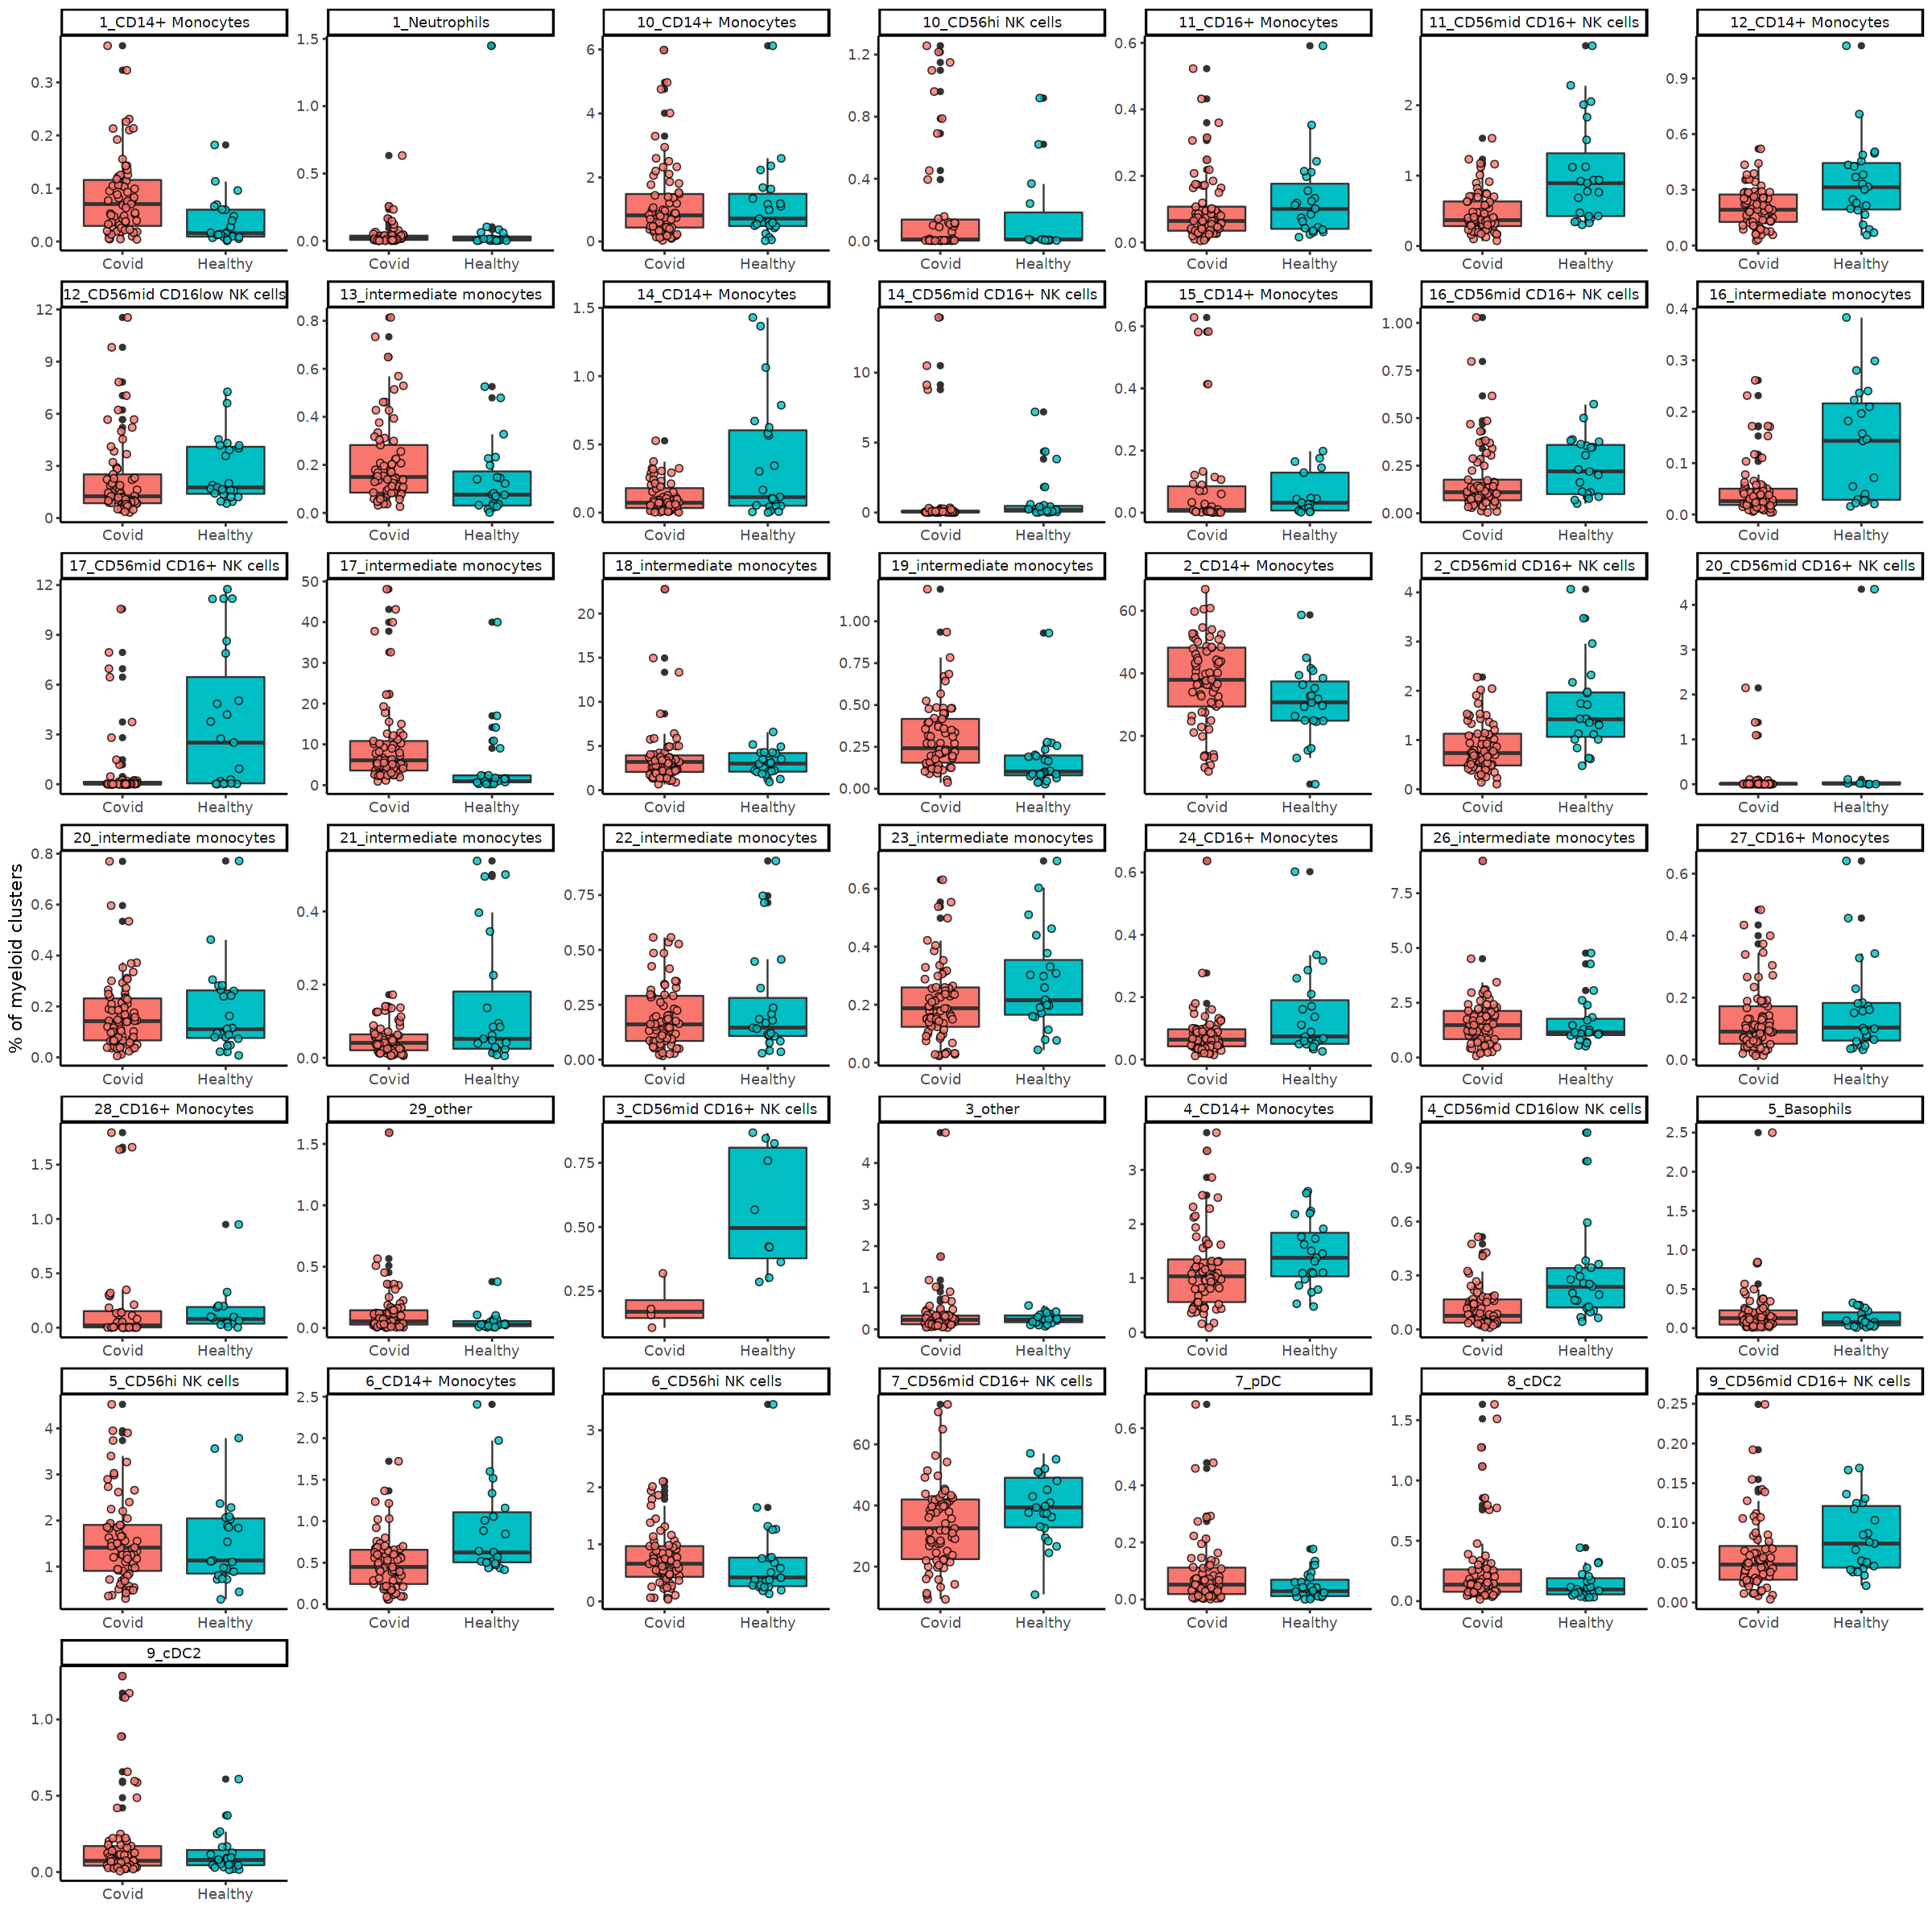

In [255]:
# by cluster
fig.size(20,20)
ggplot(celltype_freq_meta, aes(x=Status,y=freq_live*100, fill = Status)) + 
geom_boxplot() + 
    geom_jitter(shape=21,position = position_jitterdodge(jitter.width = .3,dodge.width = .8),alpha=.8,size=2) +
facet_wrap(~FlowSOM_meta_spe_anno, scales="free") + theme_classic(base_size = 13) + ylab("% of myeloid clusters") + xlab("") + theme(legend.position = "none")

In [246]:
# by cell type
celltype_freq_meta <- celltype_freq_meta %>% mutate(celltype = str_extract(FlowSOM_meta_spe_anno, "[^_]+$")) %>%
                      group_by(PBID, celltype) %>% mutate(avg_celltype = sum(freq_live))


Adding missing grouping variables: `PBID`, `celltype`


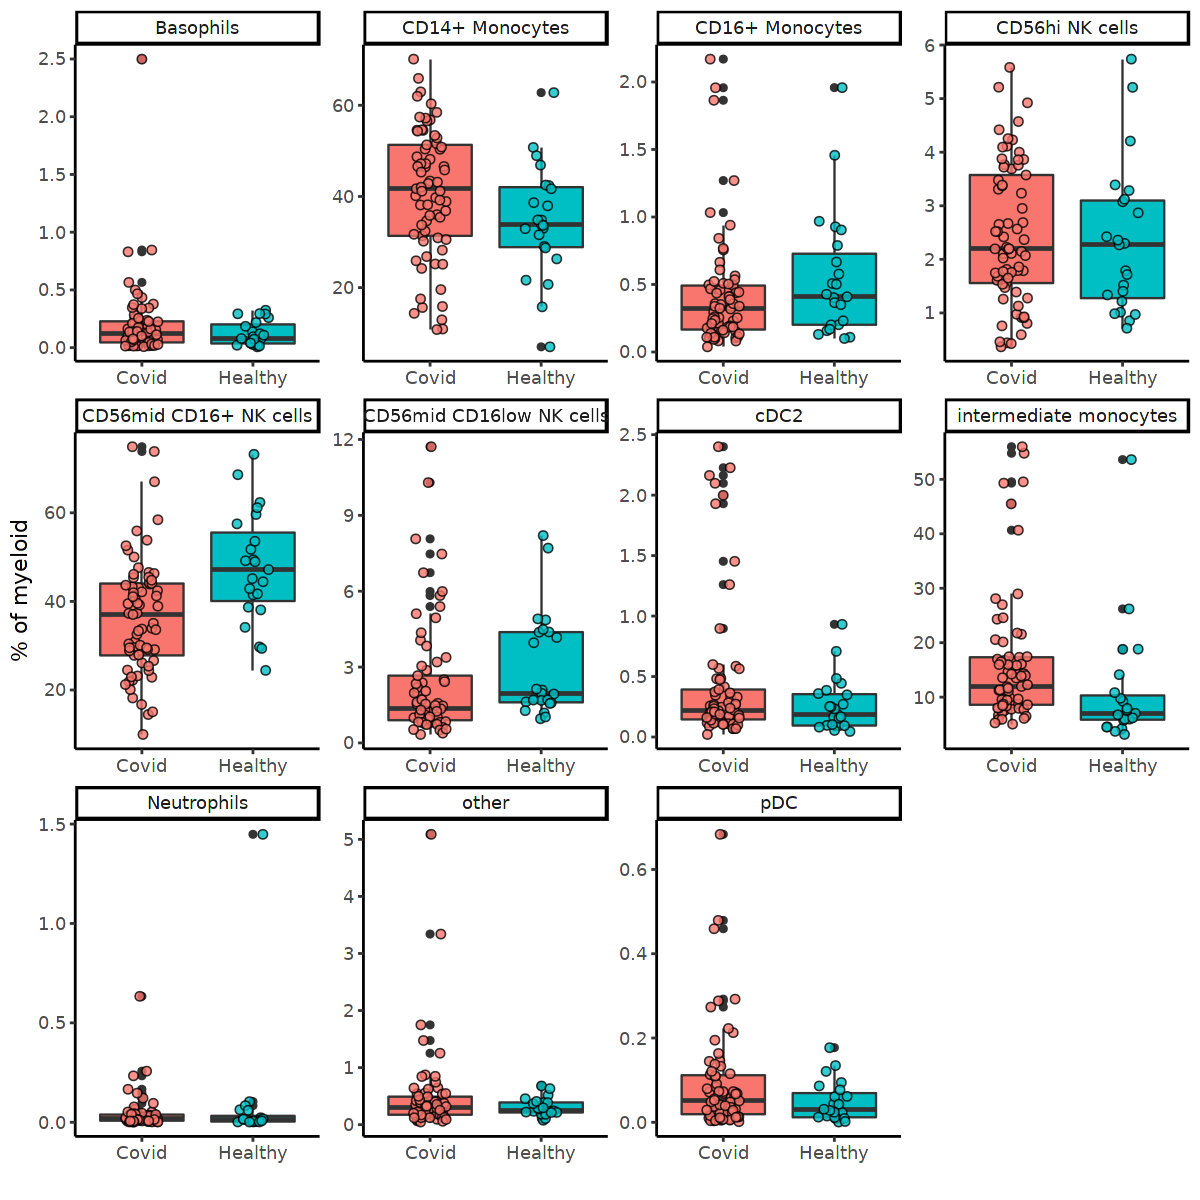

In [253]:
fig.size(10,10)

celltype_freq_adj <- celltype_freq_meta %>% select(c(avg_celltype, Status)) %>% distinct()
ggplot(celltype_freq_adj,aes(x=Status,y=avg_celltype*100, fill = Status)) + 
geom_boxplot() + 
    geom_jitter(shape=21,position = position_jitterdodge(jitter.width = .3,dodge.width = .8),alpha=.8,size=2) +
facet_wrap(~celltype, scales="free") + theme_classic(base_size = 13) + ylab("% of myeloid") + xlab("") + theme(legend.position = "none")

### Recovered vs long COVID

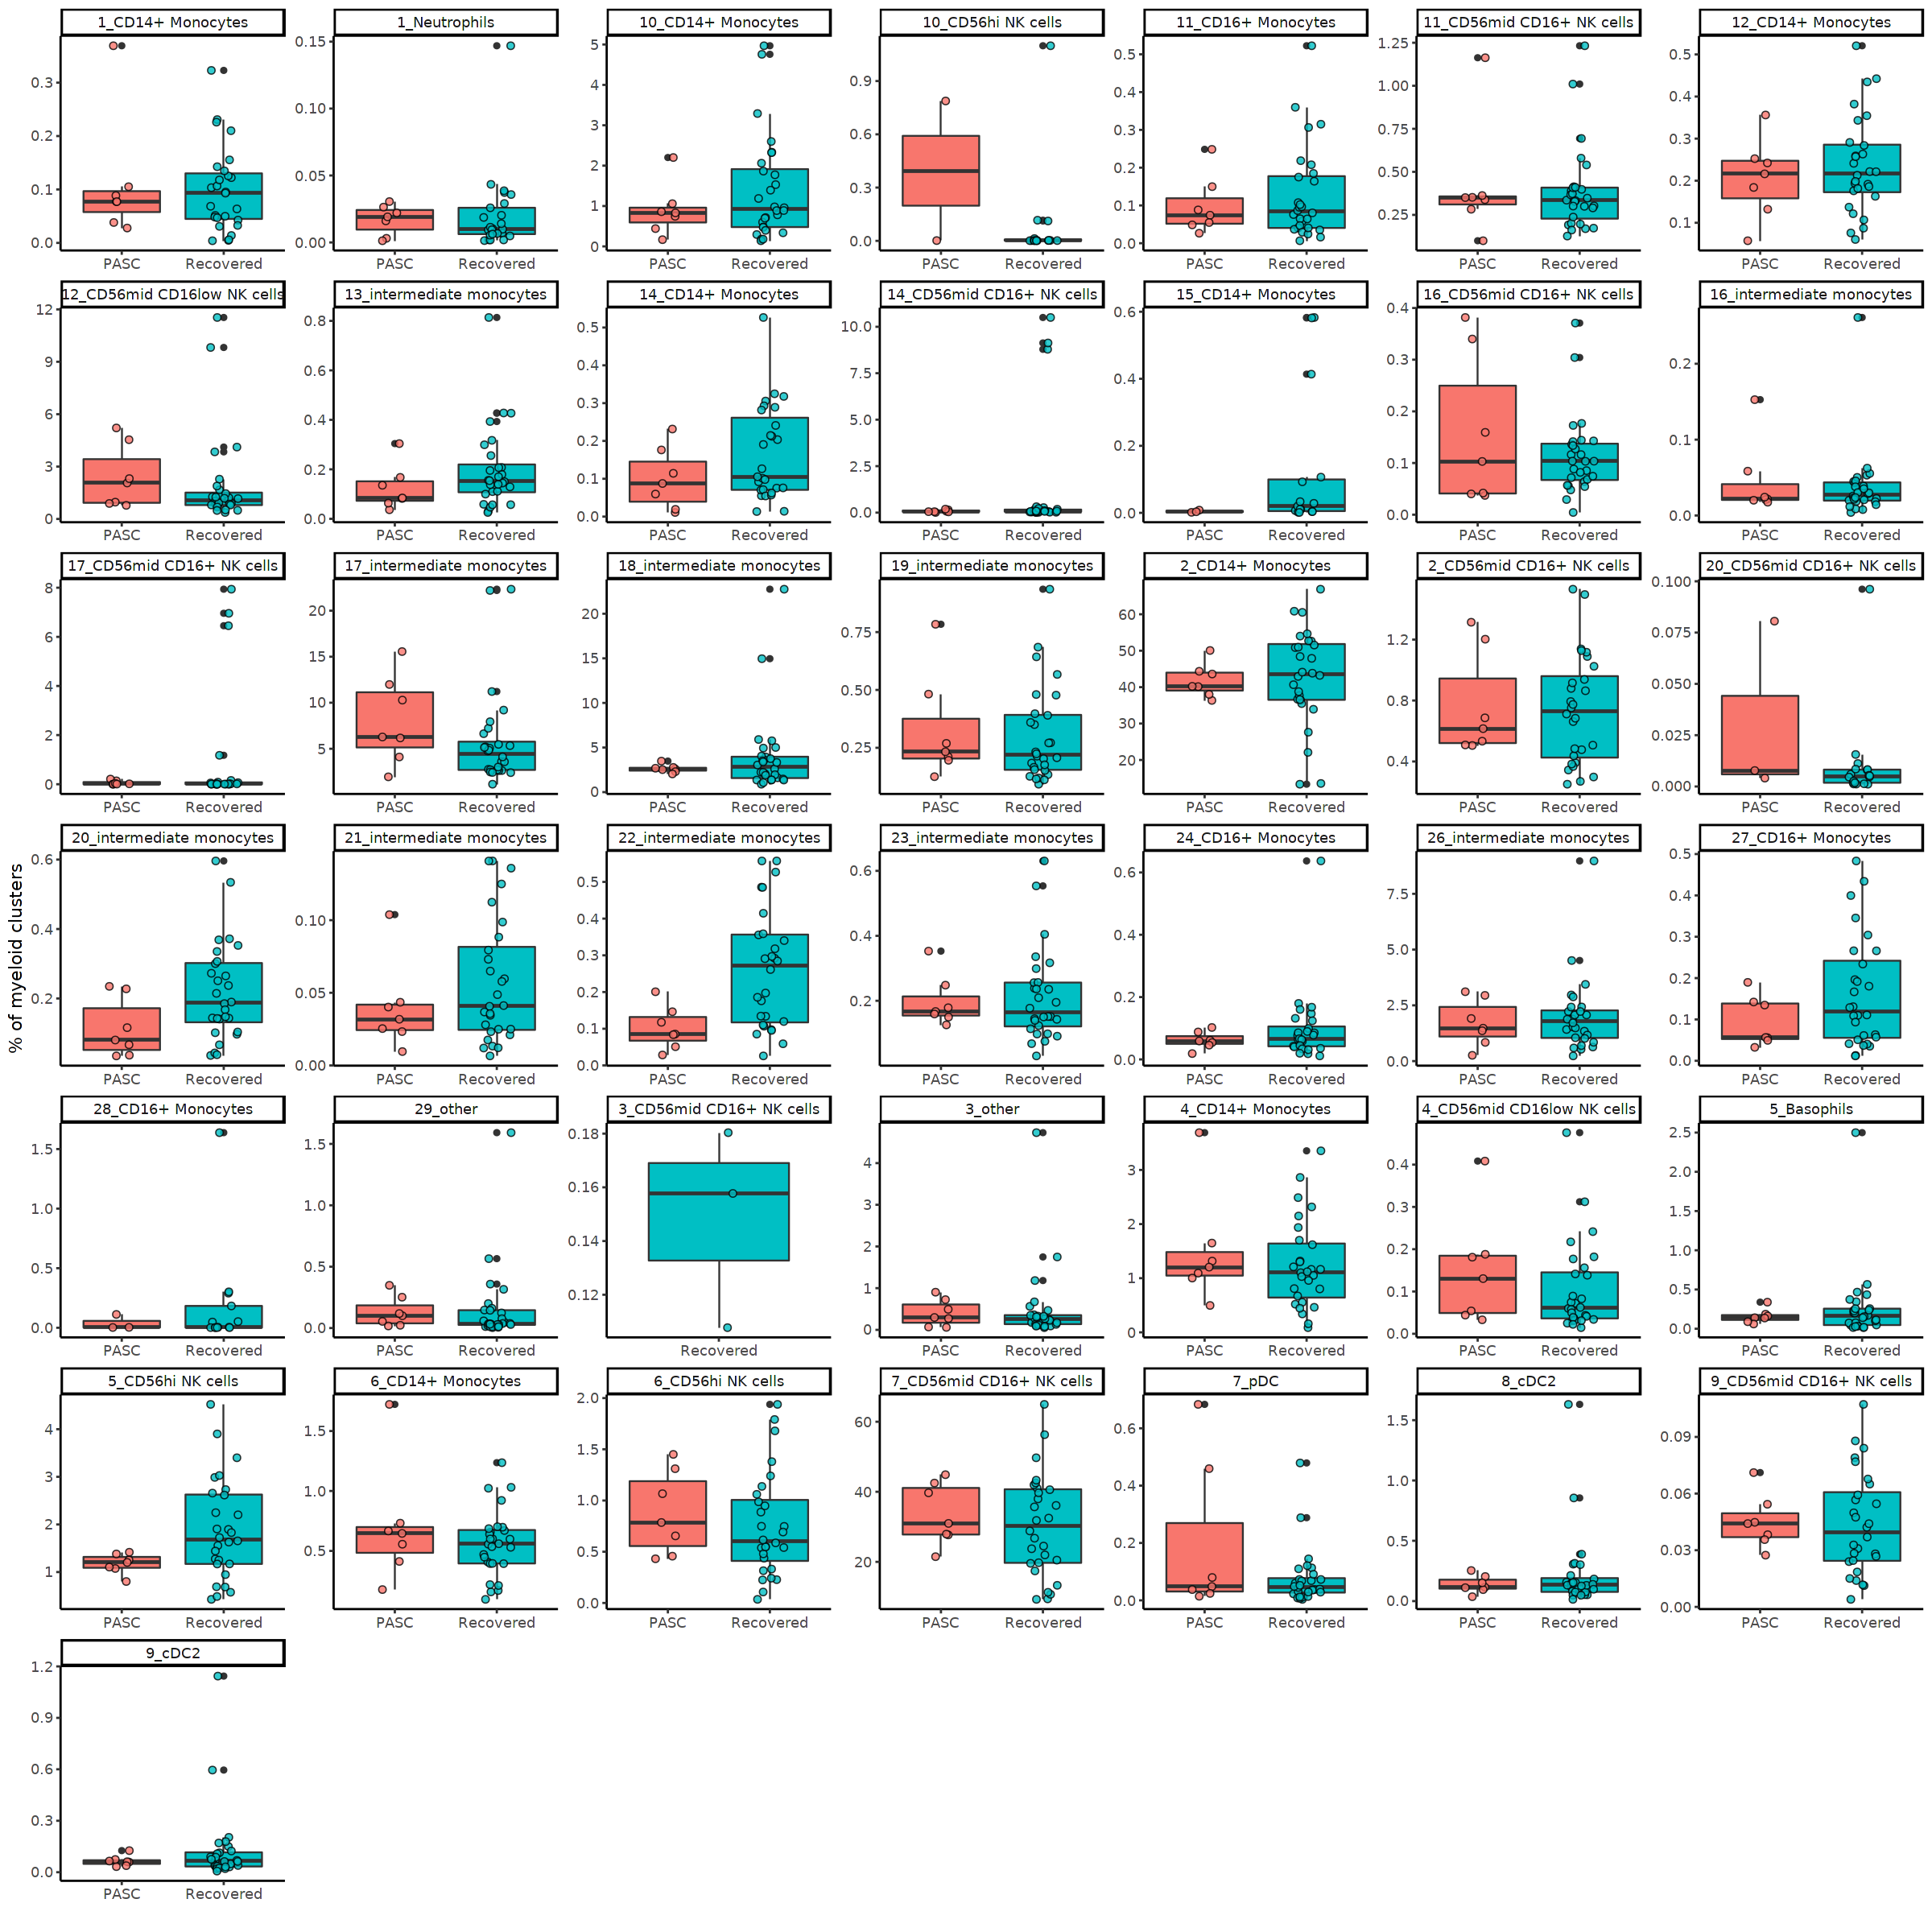

In [281]:
# by cluster
fig.size(20,20)
ggplot(celltype_freq_meta %>% filter(Stage %in% c("Recovered", "PASC")), aes(x=Stage,y=freq_live*100, fill = Stage)) + 
geom_boxplot() + 
    geom_jitter(shape=21,position = position_jitterdodge(jitter.width = .3,dodge.width = .8),alpha=.8,size=2) +
facet_wrap(~FlowSOM_meta_spe_anno, scales="free") + theme_classic(base_size = 13) + ylab("% of myeloid clusters") + xlab("") + theme(legend.position = "none")

Adding missing grouping variables: `PBID`, `celltype`


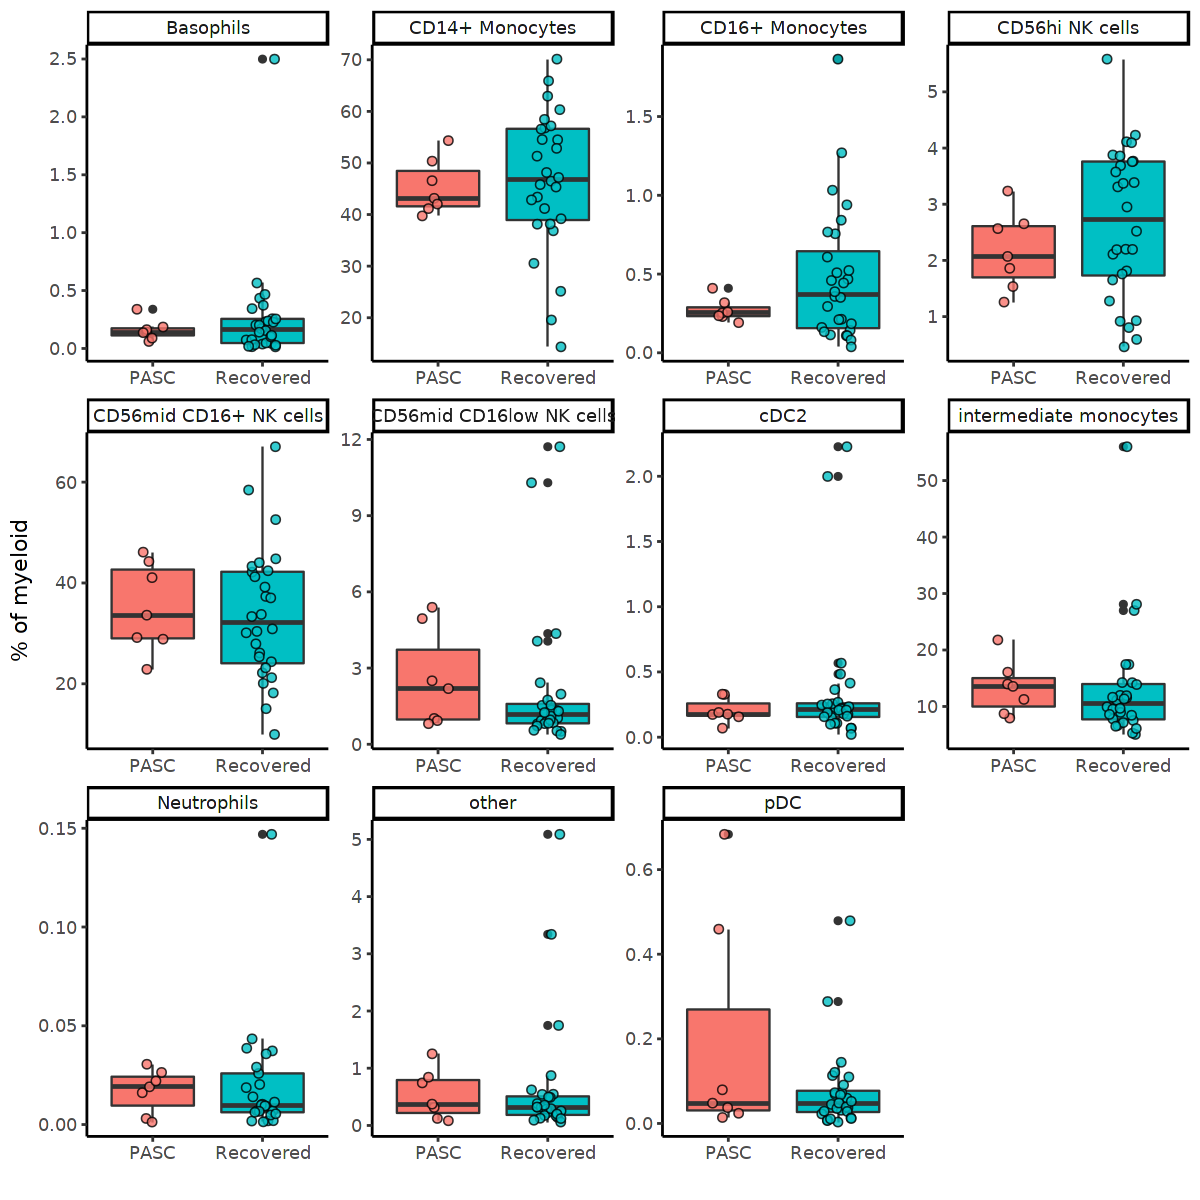

In [283]:
# by cell type
fig.size(10,10)

celltype_freq_adj <- celltype_freq_meta %>% select(c(avg_celltype, Stage)) %>% distinct()
ggplot(celltype_freq_adj %>% filter(Stage %in% c("Recovered", "PASC")),aes(x=Stage,y=avg_celltype*100, fill = Stage)) + 
geom_boxplot() + 
    geom_jitter(shape=21,position = position_jitterdodge(jitter.width = .3,dodge.width = .8),alpha=.8,size=2) +
facet_wrap(~celltype, scales="free") + theme_classic(base_size = 13) + ylab("% of myeloid") + xlab("") + theme(legend.position = "none")

### COVID infection timepoints

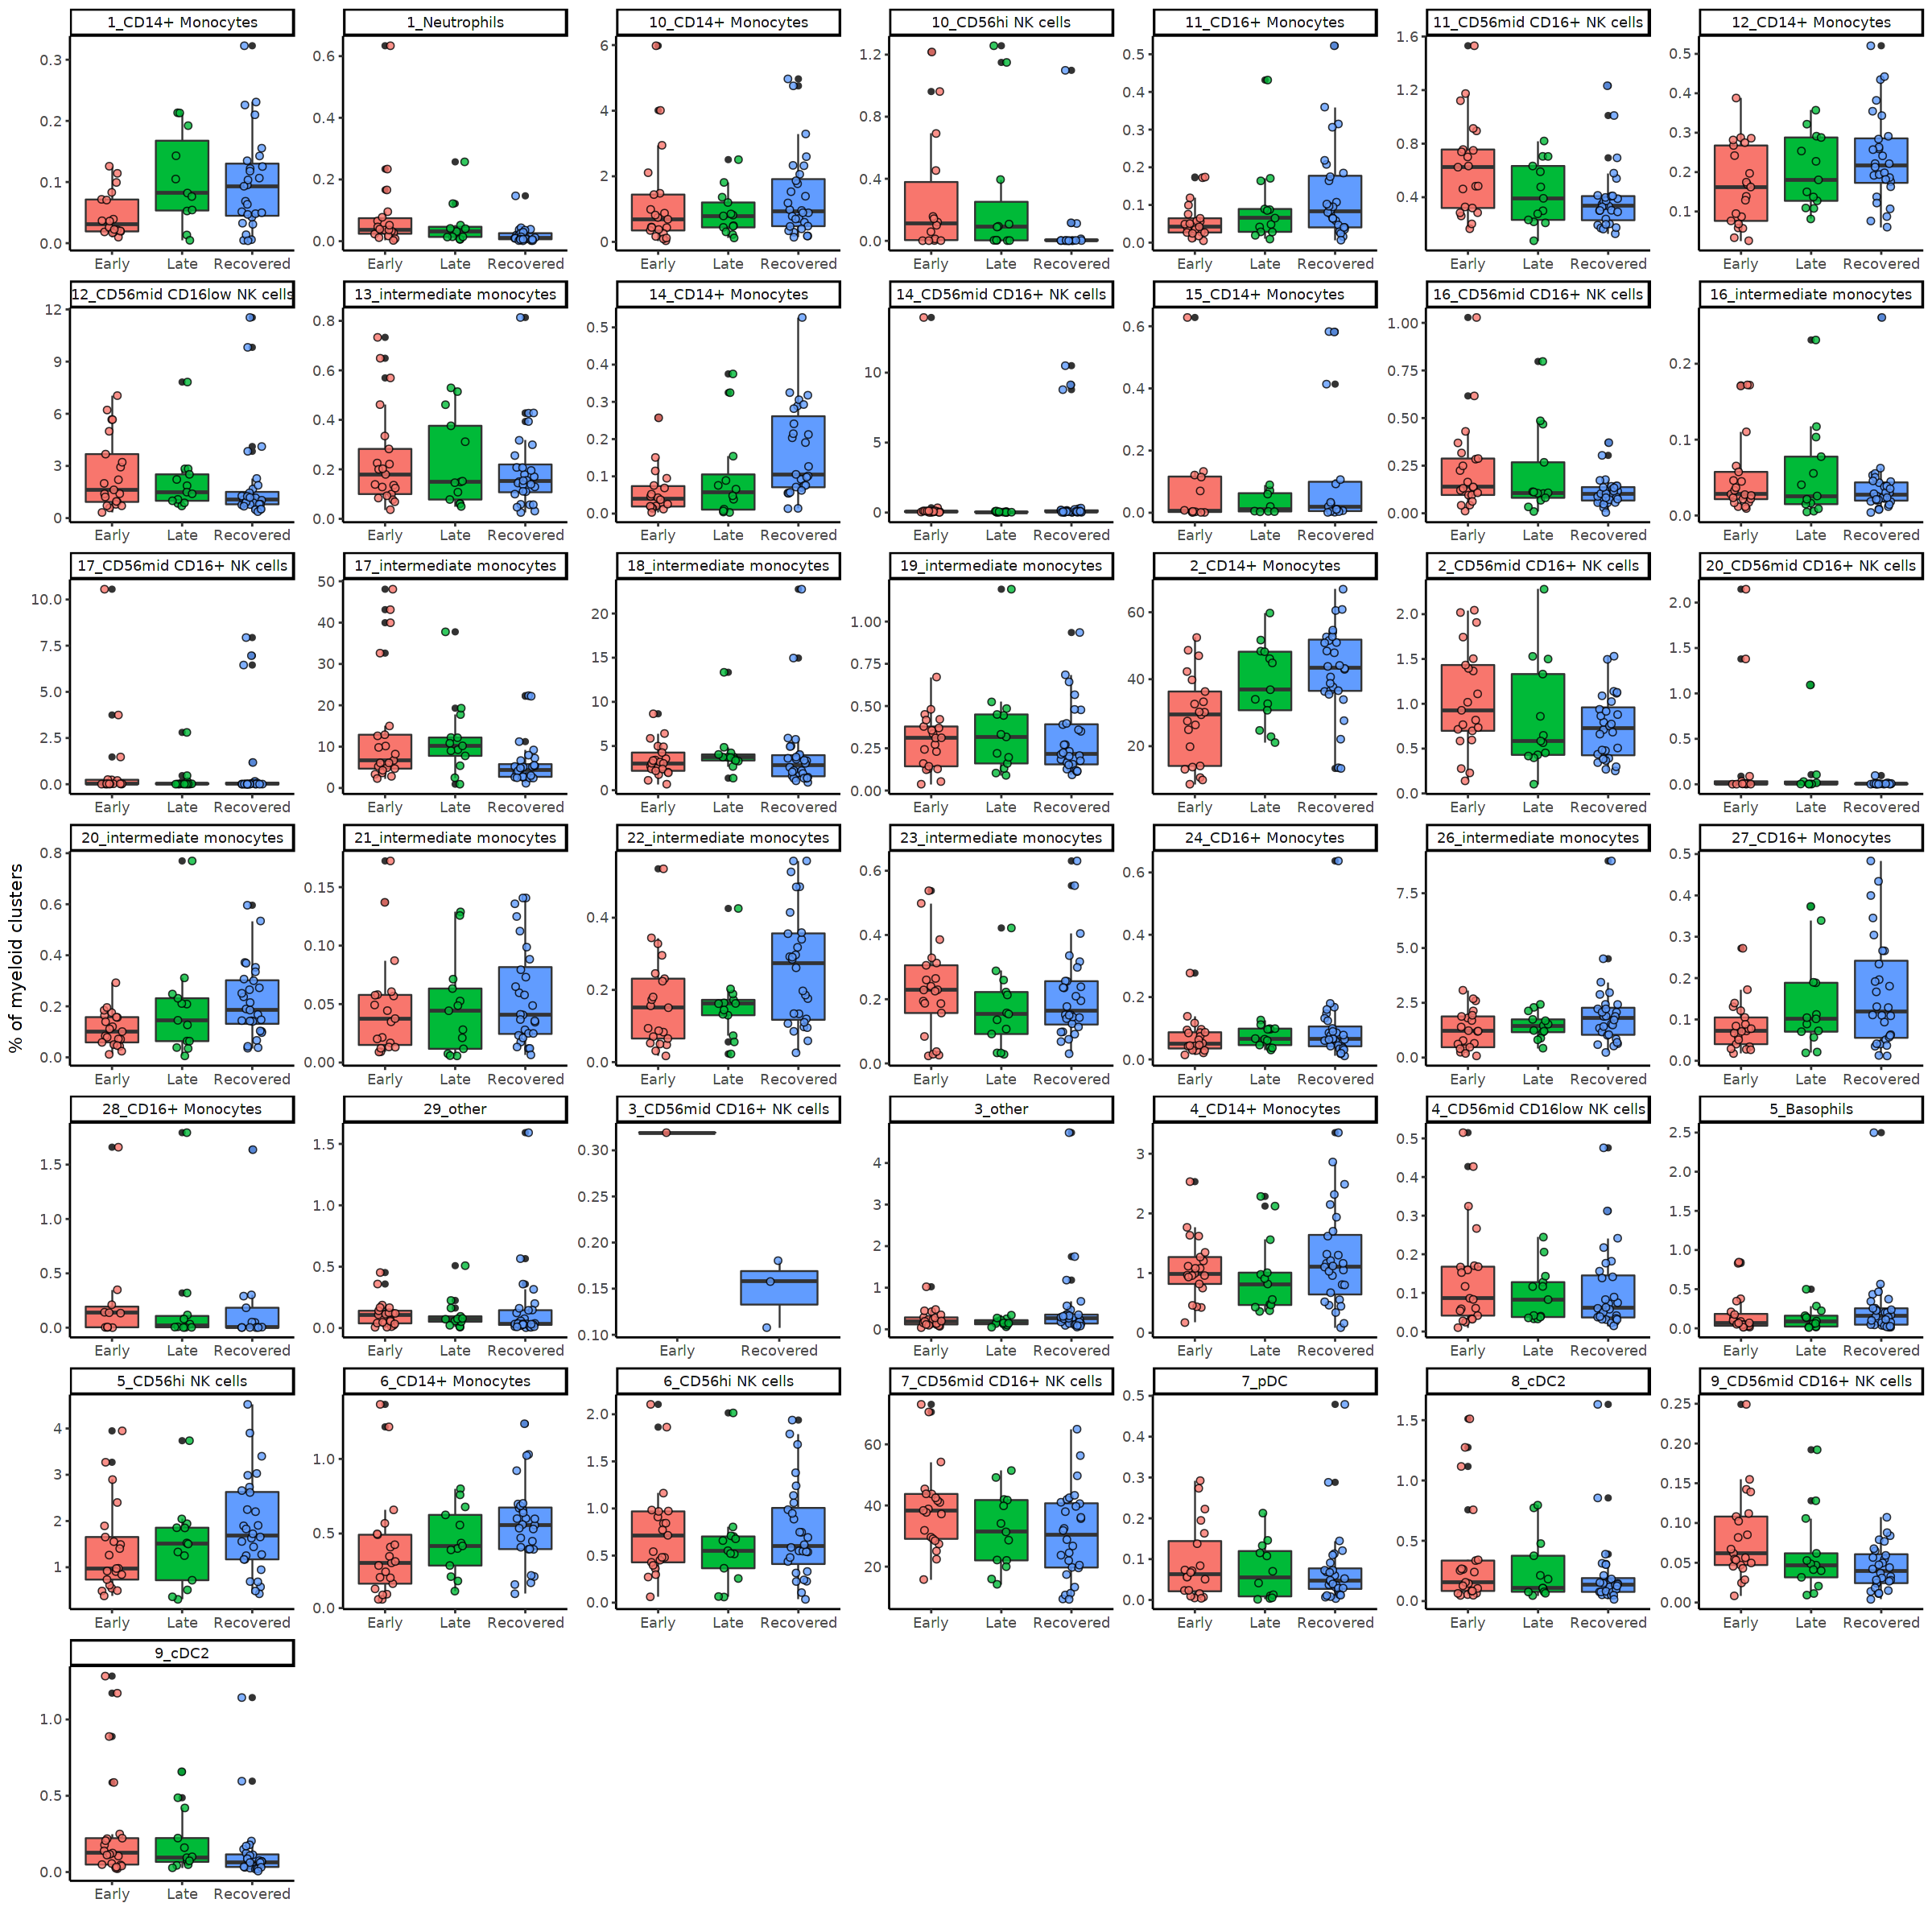

In [287]:
# by cluster
fig.size(20,20)
ggplot(celltype_freq_meta %>% filter(Stage %in% c("Early", "Late", "Recovered")), aes(x=Stage,y=freq_live*100, fill = Stage)) + 
geom_boxplot() + 
    geom_jitter(shape=21,position = position_jitterdodge(jitter.width = .3,dodge.width = .8),alpha=.8,size=2) +
facet_wrap(~FlowSOM_meta_spe_anno, scales="free") + theme_classic(base_size = 13) + ylab("% of myeloid clusters") + xlab("") + theme(legend.position = "none")

Adding missing grouping variables: `PBID`, `celltype`


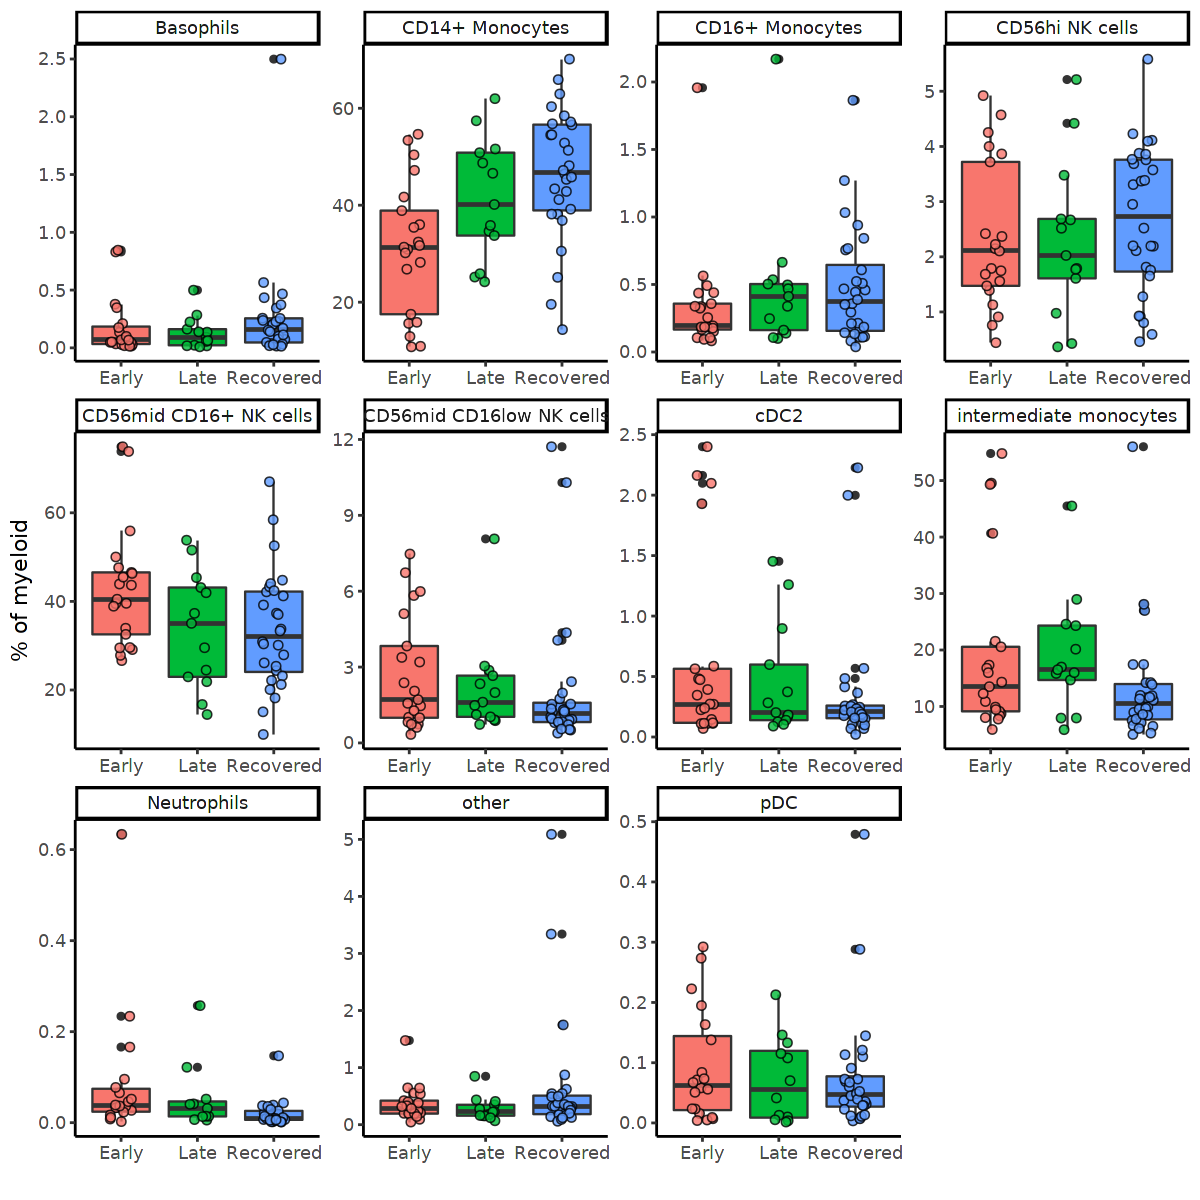

In [318]:
# by cell type
fig.size(10,10)

celltype_freq_adj <- celltype_freq_meta %>% select(c(avg_celltype, Stage)) %>% distinct()
ggplot(celltype_freq_adj %>% filter(Stage %in% c("Early", "Late", "Recovered")),aes(x=Stage,y=avg_celltype*100, fill = Stage)) + 
geom_boxplot() + 
    geom_jitter(shape=21,position = position_jitterdodge(jitter.width = .3,dodge.width = .8),alpha=.8,size=2) +
facet_wrap(~celltype, scales="free") + theme_classic(base_size = 13) + ylab("% of myeloid") + xlab("") + theme(legend.position = "none")

### Old vs young

In [271]:
celltype_freq_meta$age_bin <- str_replace(celltype_freq_meta$age_bin, "eradults", "") %>% 
                                factor(levels = c("young", "old"))


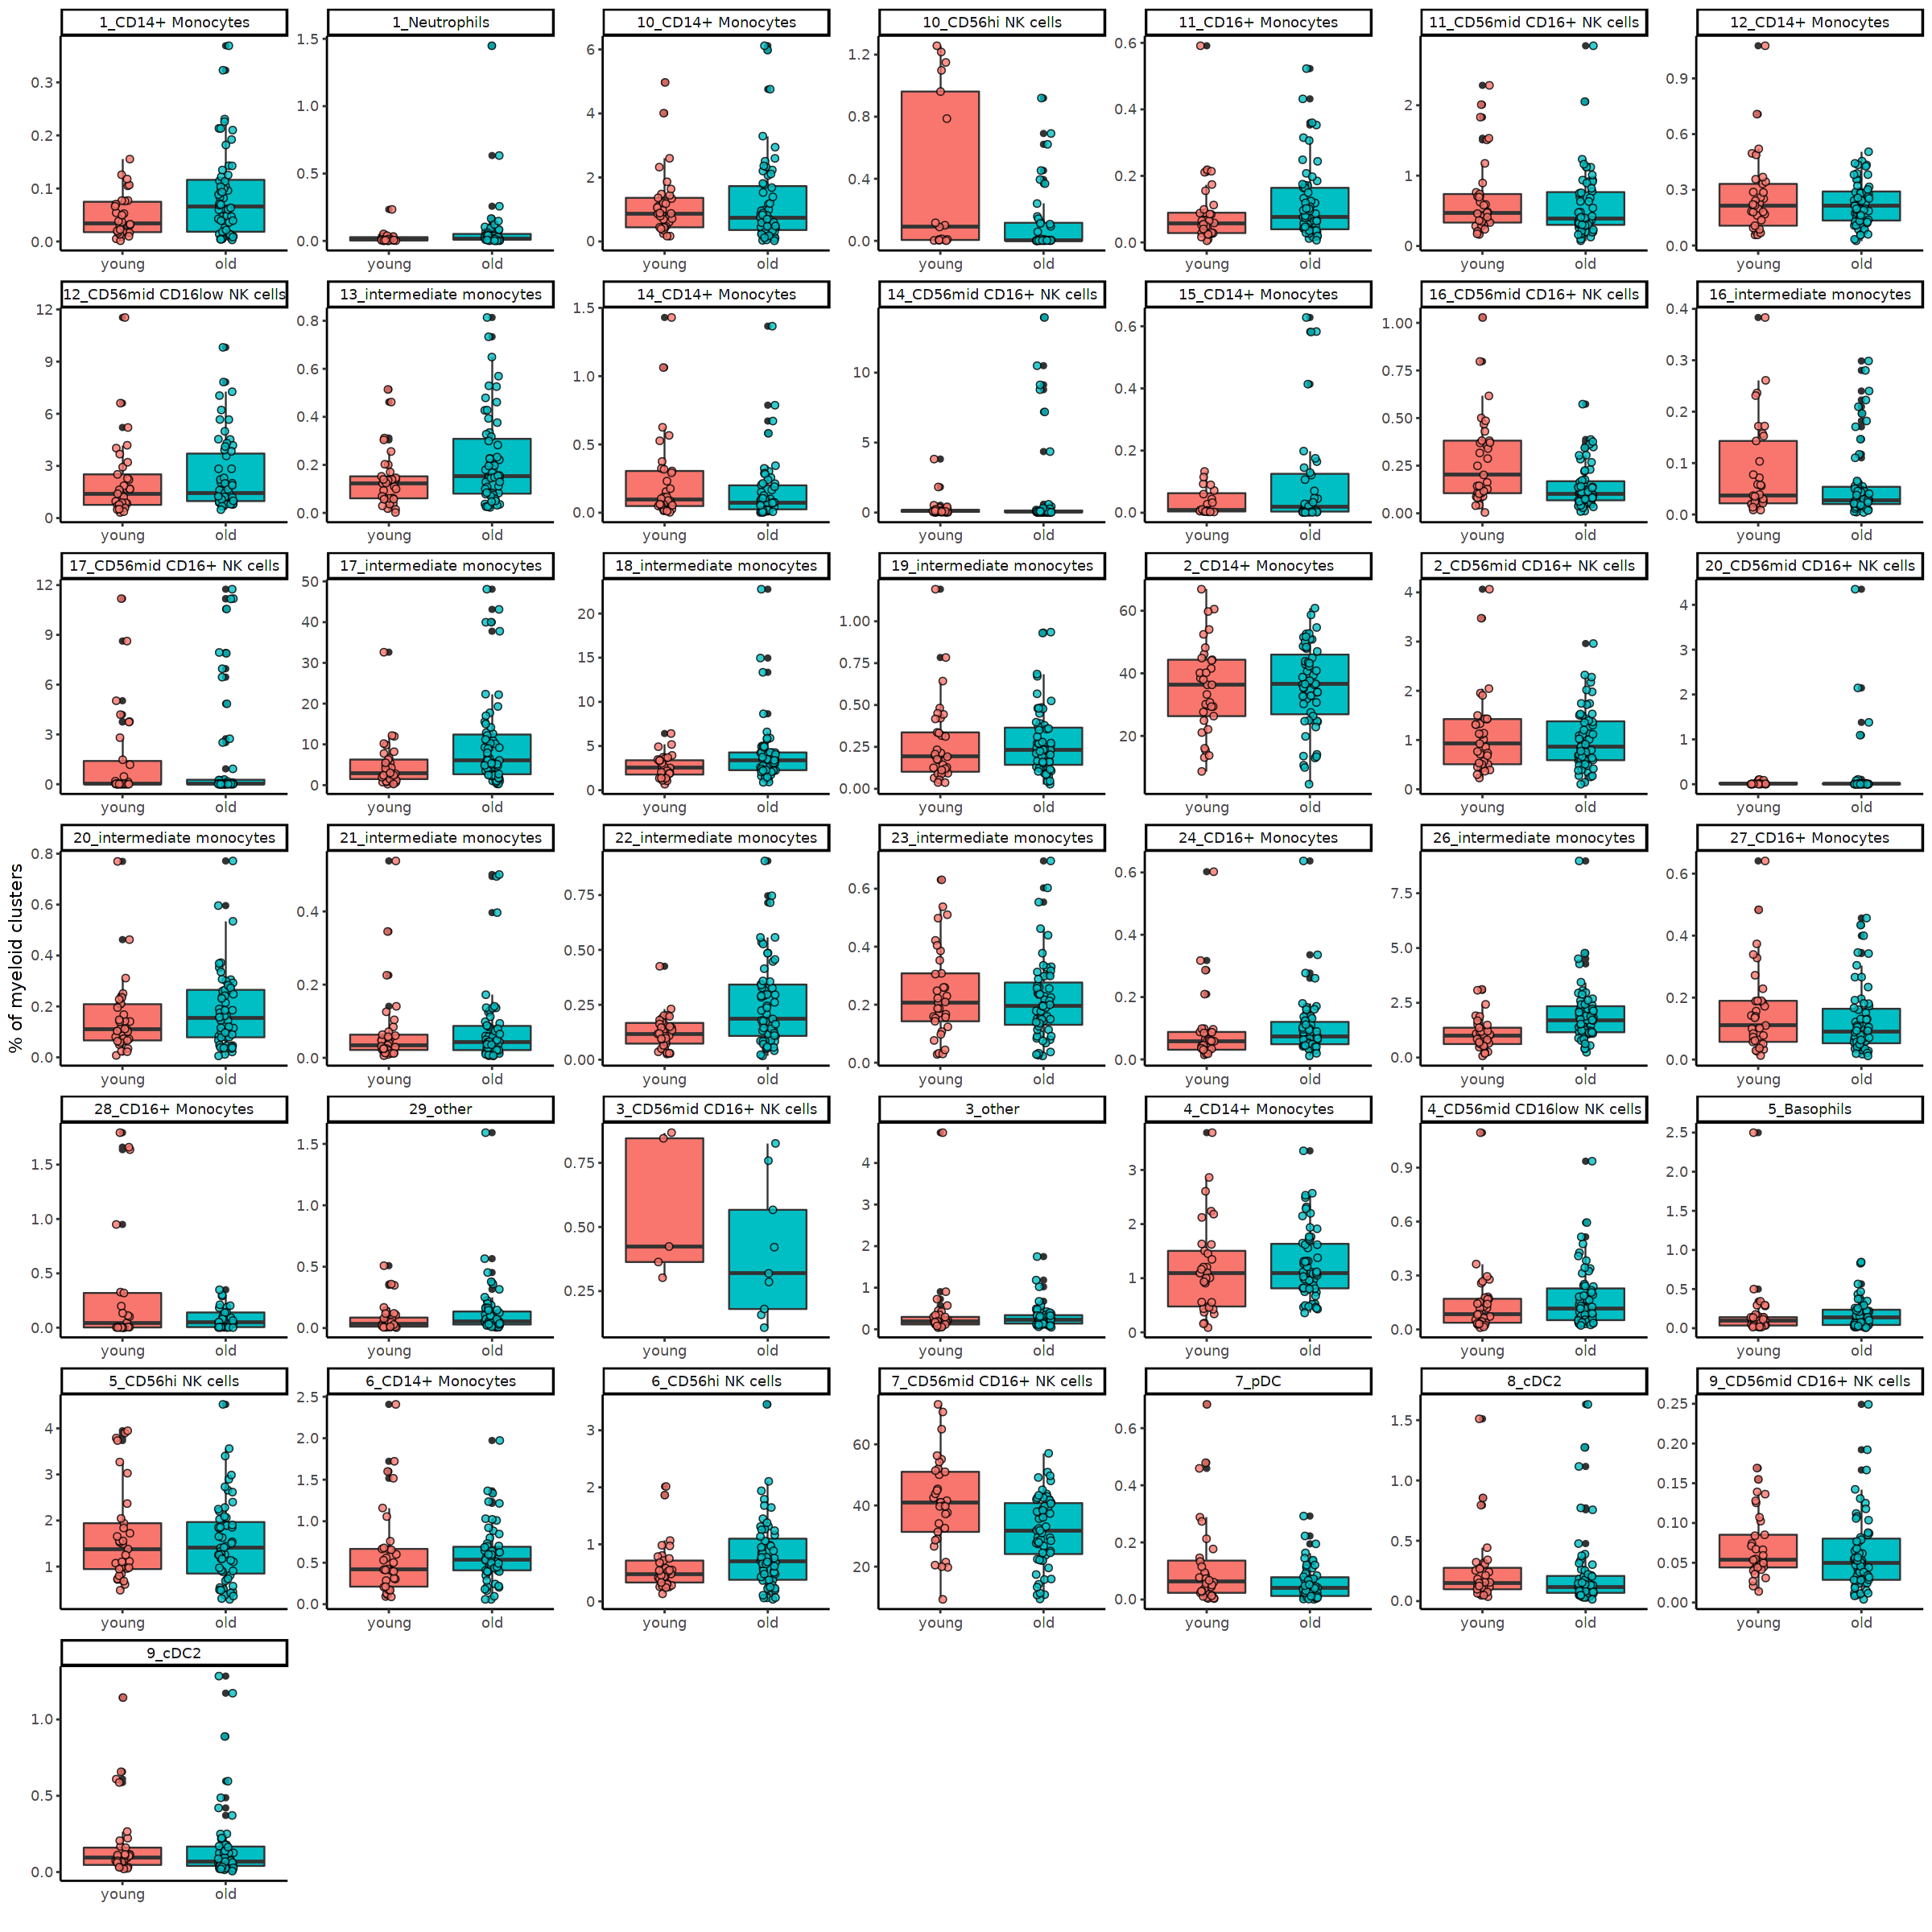

In [272]:
# by cluster
fig.size(20,20)
ggplot(celltype_freq_meta, aes(x=age_bin,y=freq_live*100, fill = age_bin)) + 
geom_boxplot() + 
    geom_jitter(shape=21,position = position_jitterdodge(jitter.width = .3,dodge.width = .8),alpha=.8,size=2) +
facet_wrap(~FlowSOM_meta_spe_anno, scales="free") + theme_classic(base_size = 13) + ylab("% of myeloid clusters") + xlab("") + theme(legend.position = "none")

Adding missing grouping variables: `PBID`, `celltype`


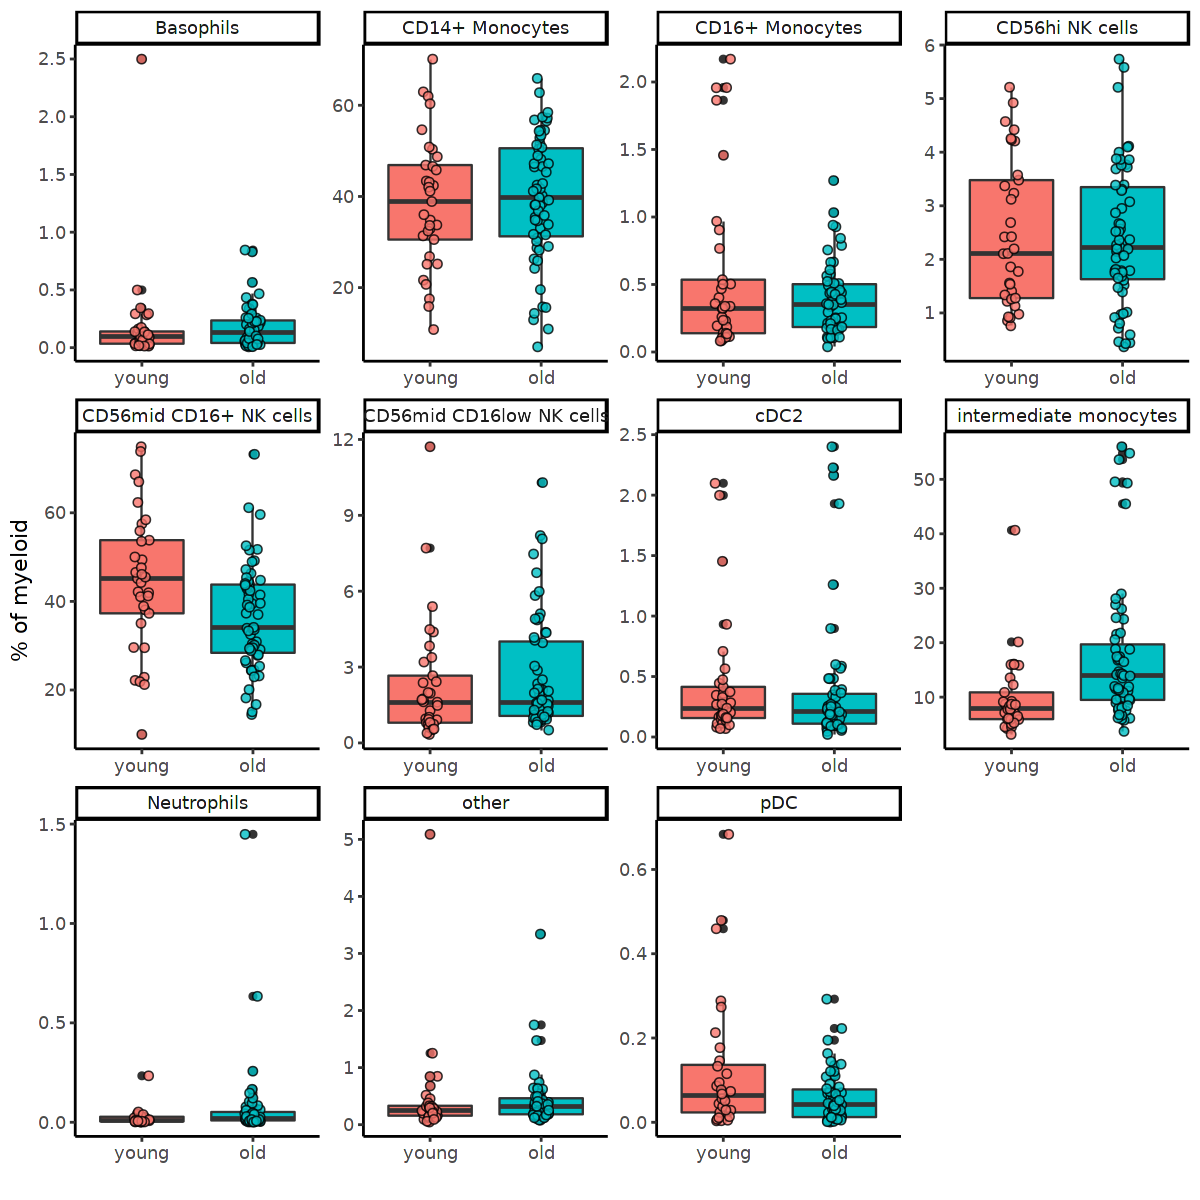

In [275]:
# by cell type
fig.size(10,10)

celltype_freq_adj <- celltype_freq_meta %>% select(c(avg_celltype, age_bin)) %>% distinct()
ggplot(celltype_freq_adj,aes(x=age_bin,y=avg_celltype*100, fill = age_bin)) + 
geom_boxplot() + 
    geom_jitter(shape=21,position = position_jitterdodge(jitter.width = .3,dodge.width = .8),alpha=.8,size=2) +
facet_wrap(~celltype, scales="free") + theme_classic(base_size = 13) + ylab("% of myeloid") + xlab("") + theme(legend.position = "none")

# MFI comparisons

In [300]:
mfi <- read_csv(paste0(base_dir, "PM1-unsupervised-clustering/output/PM1_unsupPM1_fm_norm_pm1_final_normalized_all_samples_MFI.csv")) %>% rename(pbmc_sample_id = sample_id) %>% mutate(PBID = gsub("-[0-9]*","",pbmc_sample_id))
 

Rows: 4616 Columns: 24
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): sample_id, FlowSOM_meta_spe_anno
dbl (22): CD14_logicle_aligned, CD15_logicle_aligned, CD56_logicle_aligned, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [313]:
str_replace(mfi$markers, "_logicle_aligned", "")


Warning message:
“Unknown or uninitialised column: `markers`.”


character(0)

In [314]:
mfi_long <- mfi %>% pivot_longer(cols = CD14_logicle_aligned:CD1c_logicle_aligned,names_to = "markers",values_to = "mfi") %>%
                    mutate(markers = str_replace(markers, "_logicle_aligned", ""))
                


In [320]:
mfi_meta <- left_join(mfi_long,subjectmeta,by = "PBID") %>% filter(!(grepl("IMM19",PBID)))

In [345]:
# by cell type
mfi_meta <- mfi_meta %>% mutate(celltype = str_extract(FlowSOM_meta_spe_anno, "[^_]+$")) %>%
                      group_by(PBID, markers, celltype) %>% mutate(avg_mfi = mean(mfi))

In [348]:
mfi_celltype <- mfi_meta %>% select(c(avg_mfi, mfi, Stage, markers, age_bin, Status)) %>% distinct()

Adding missing grouping variables: `PBID`, `celltype`


### COVID vs healthy

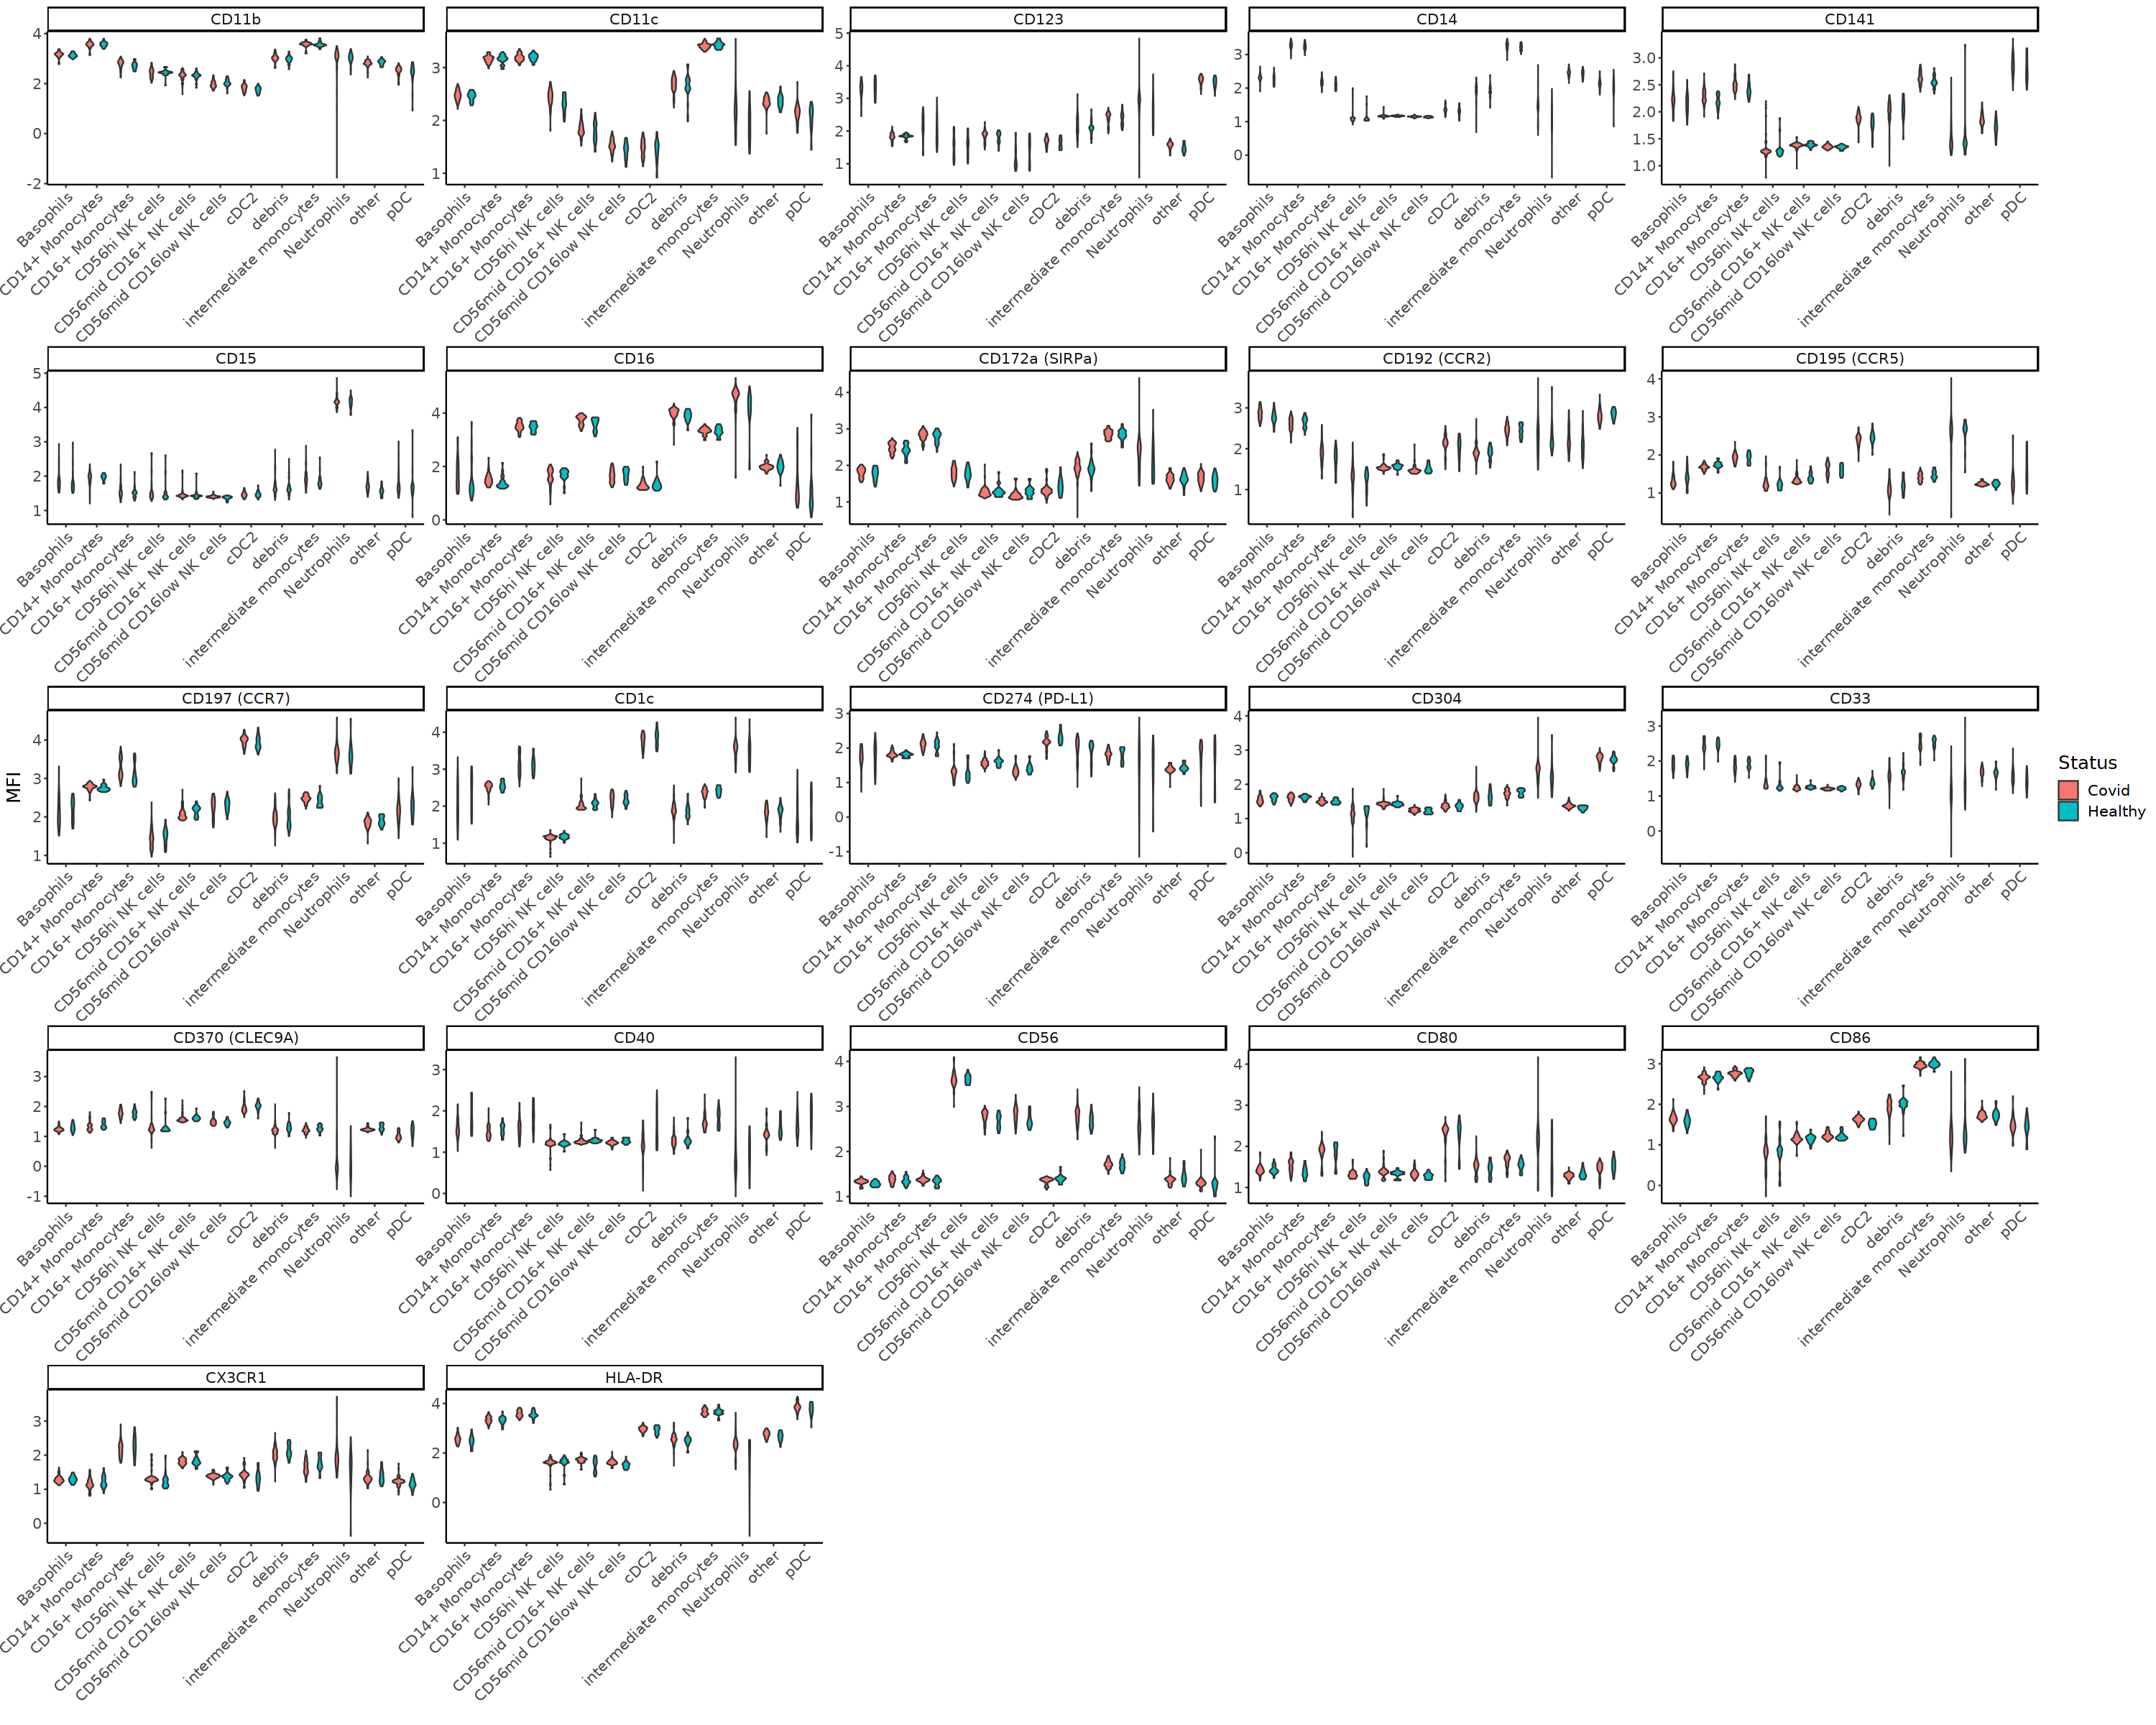

In [367]:
# by celltype
fig.size(20,25) 

ggplot(mfi_celltype, aes(x=celltype,y=avg_mfi, fill = Status)) + 
    geom_violin() +
    facet_wrap(~markers, scales="free") + 
    theme_classic() + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) + theme(text = element_text(size=15)) +
    ylab("MFI") + xlab("")

### Recovered vs long COVID

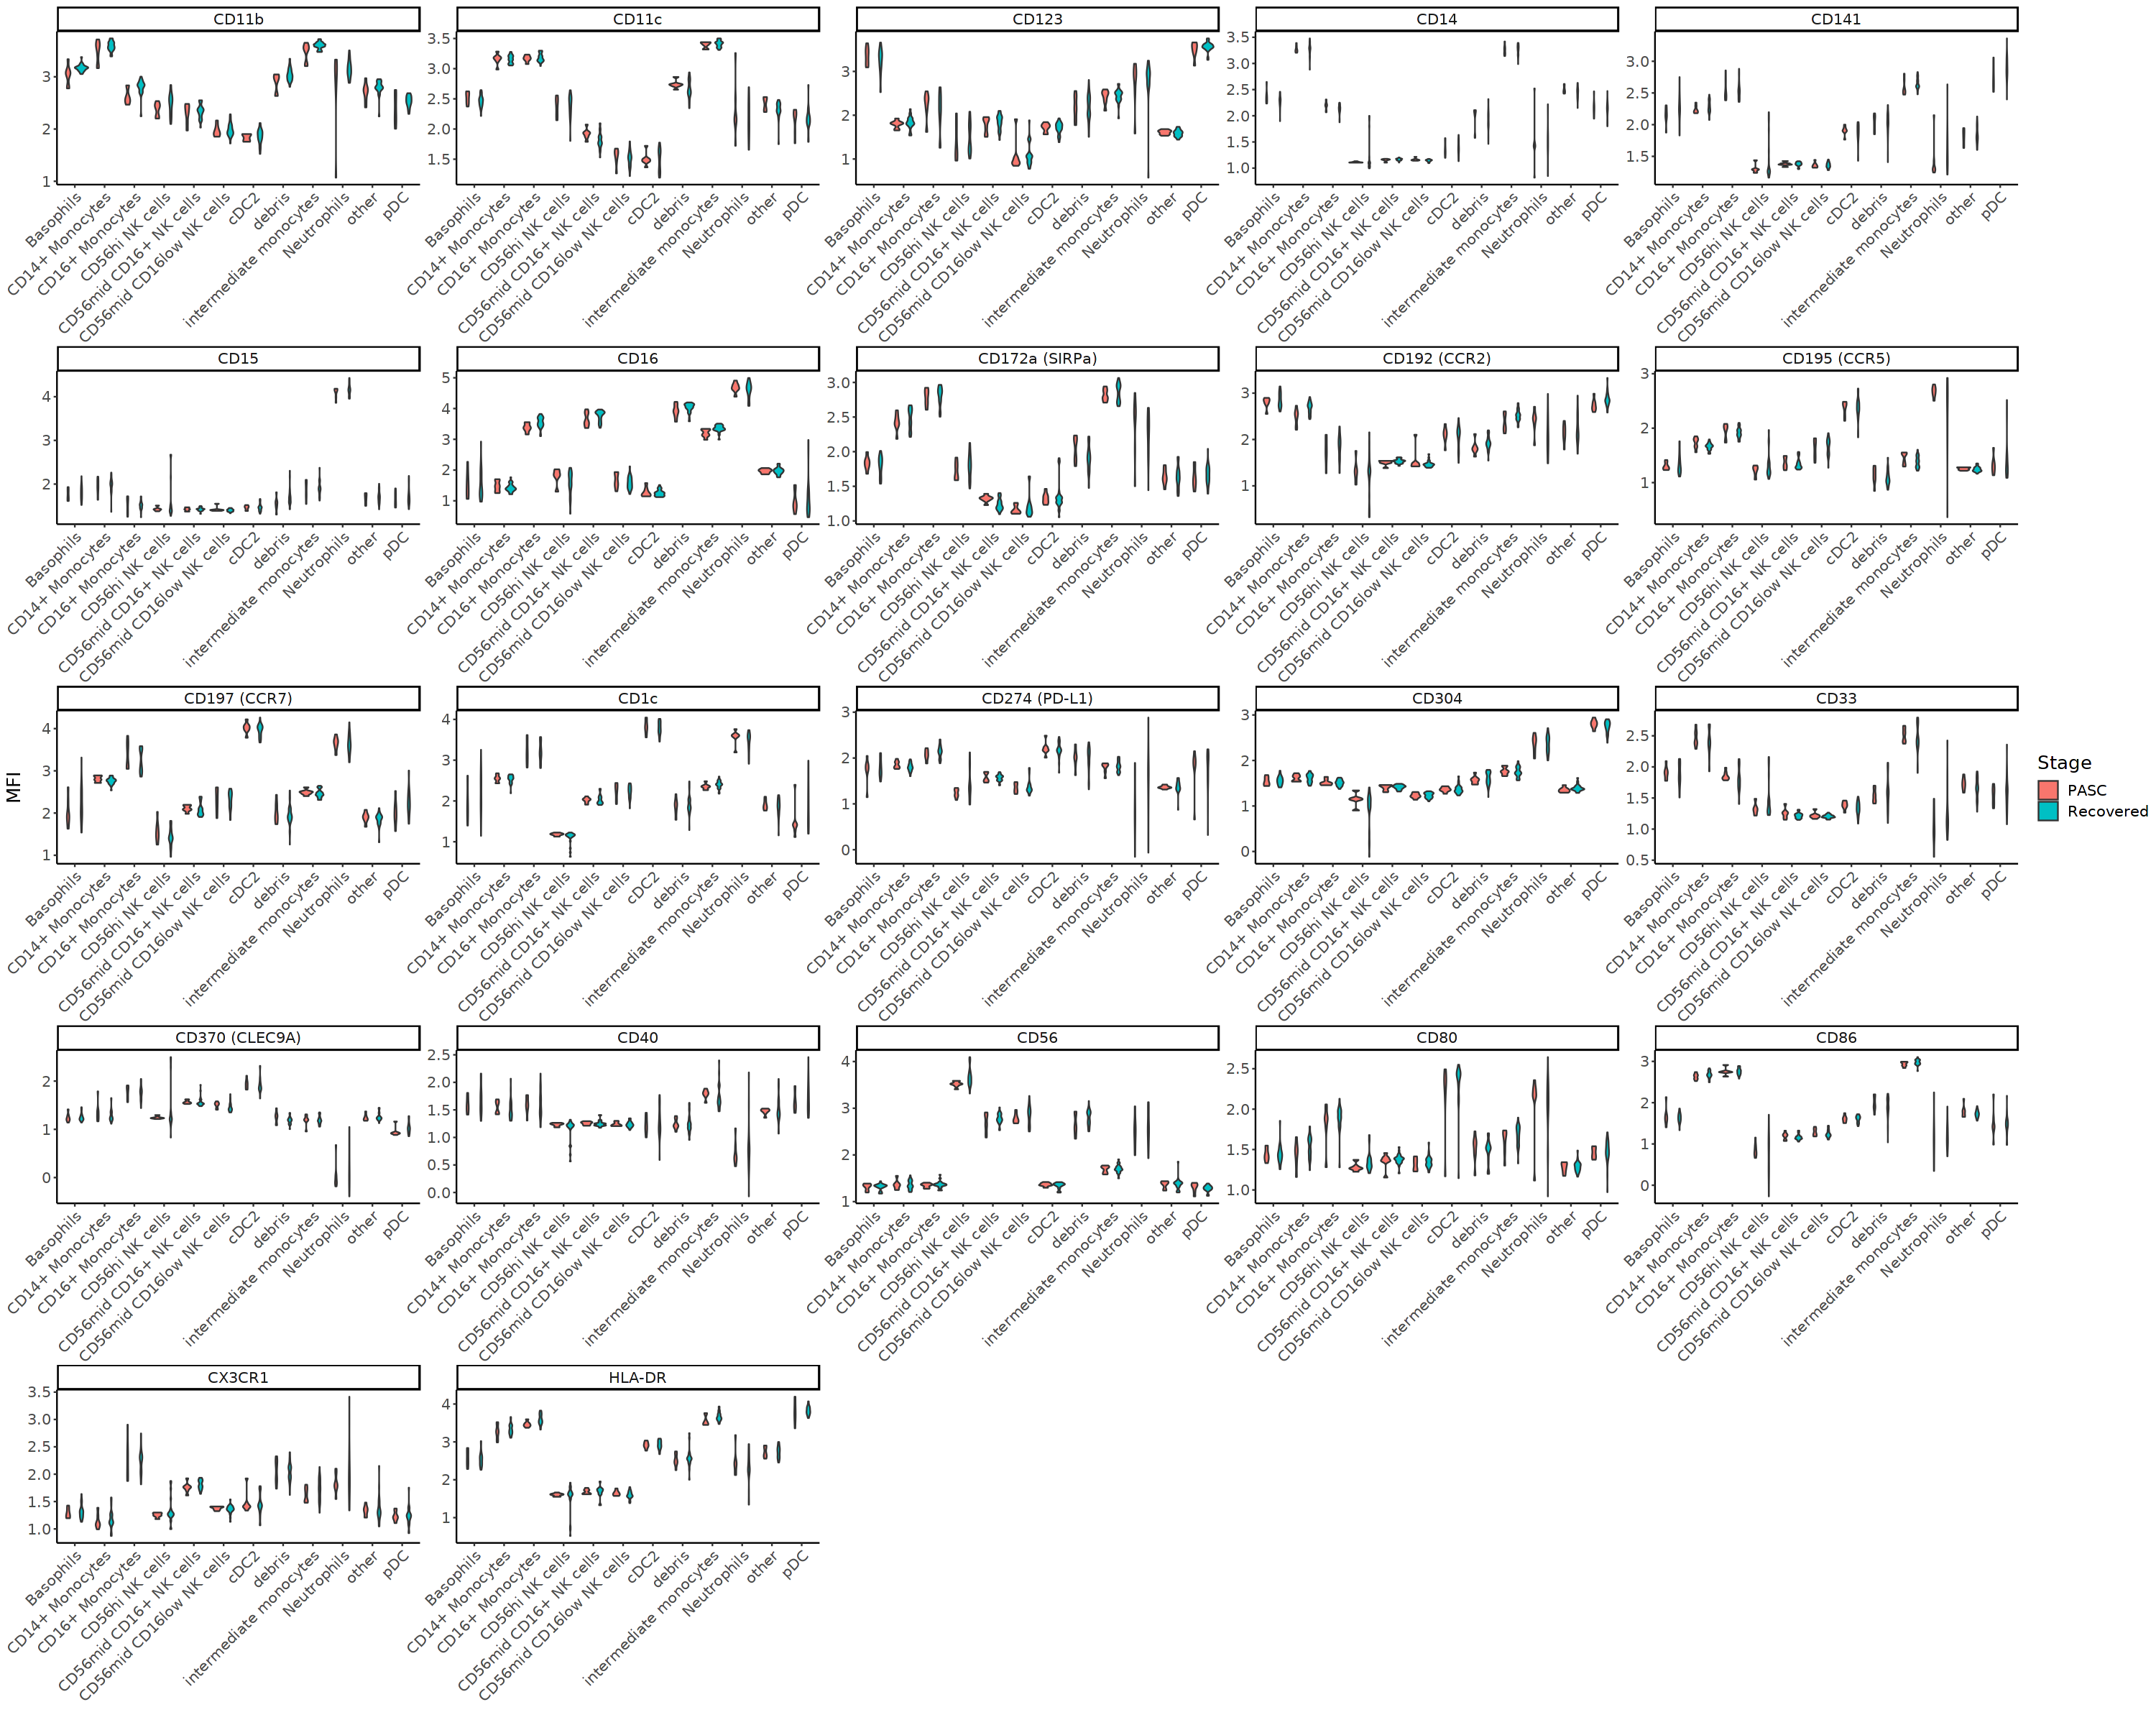

In [368]:
# by celltype
fig.size(20,25) 

ggplot(mfi_celltype %>% filter(Stage %in% c("Recovered", "PASC")), aes(x=celltype,y=avg_mfi, fill = Stage)) + 
    geom_violin() +
    facet_wrap(~markers, scales="free") + 
    theme_classic() + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) + ylab("MFI") + xlab("") + theme(text = element_text(size=15))

### COVID infection timepoints

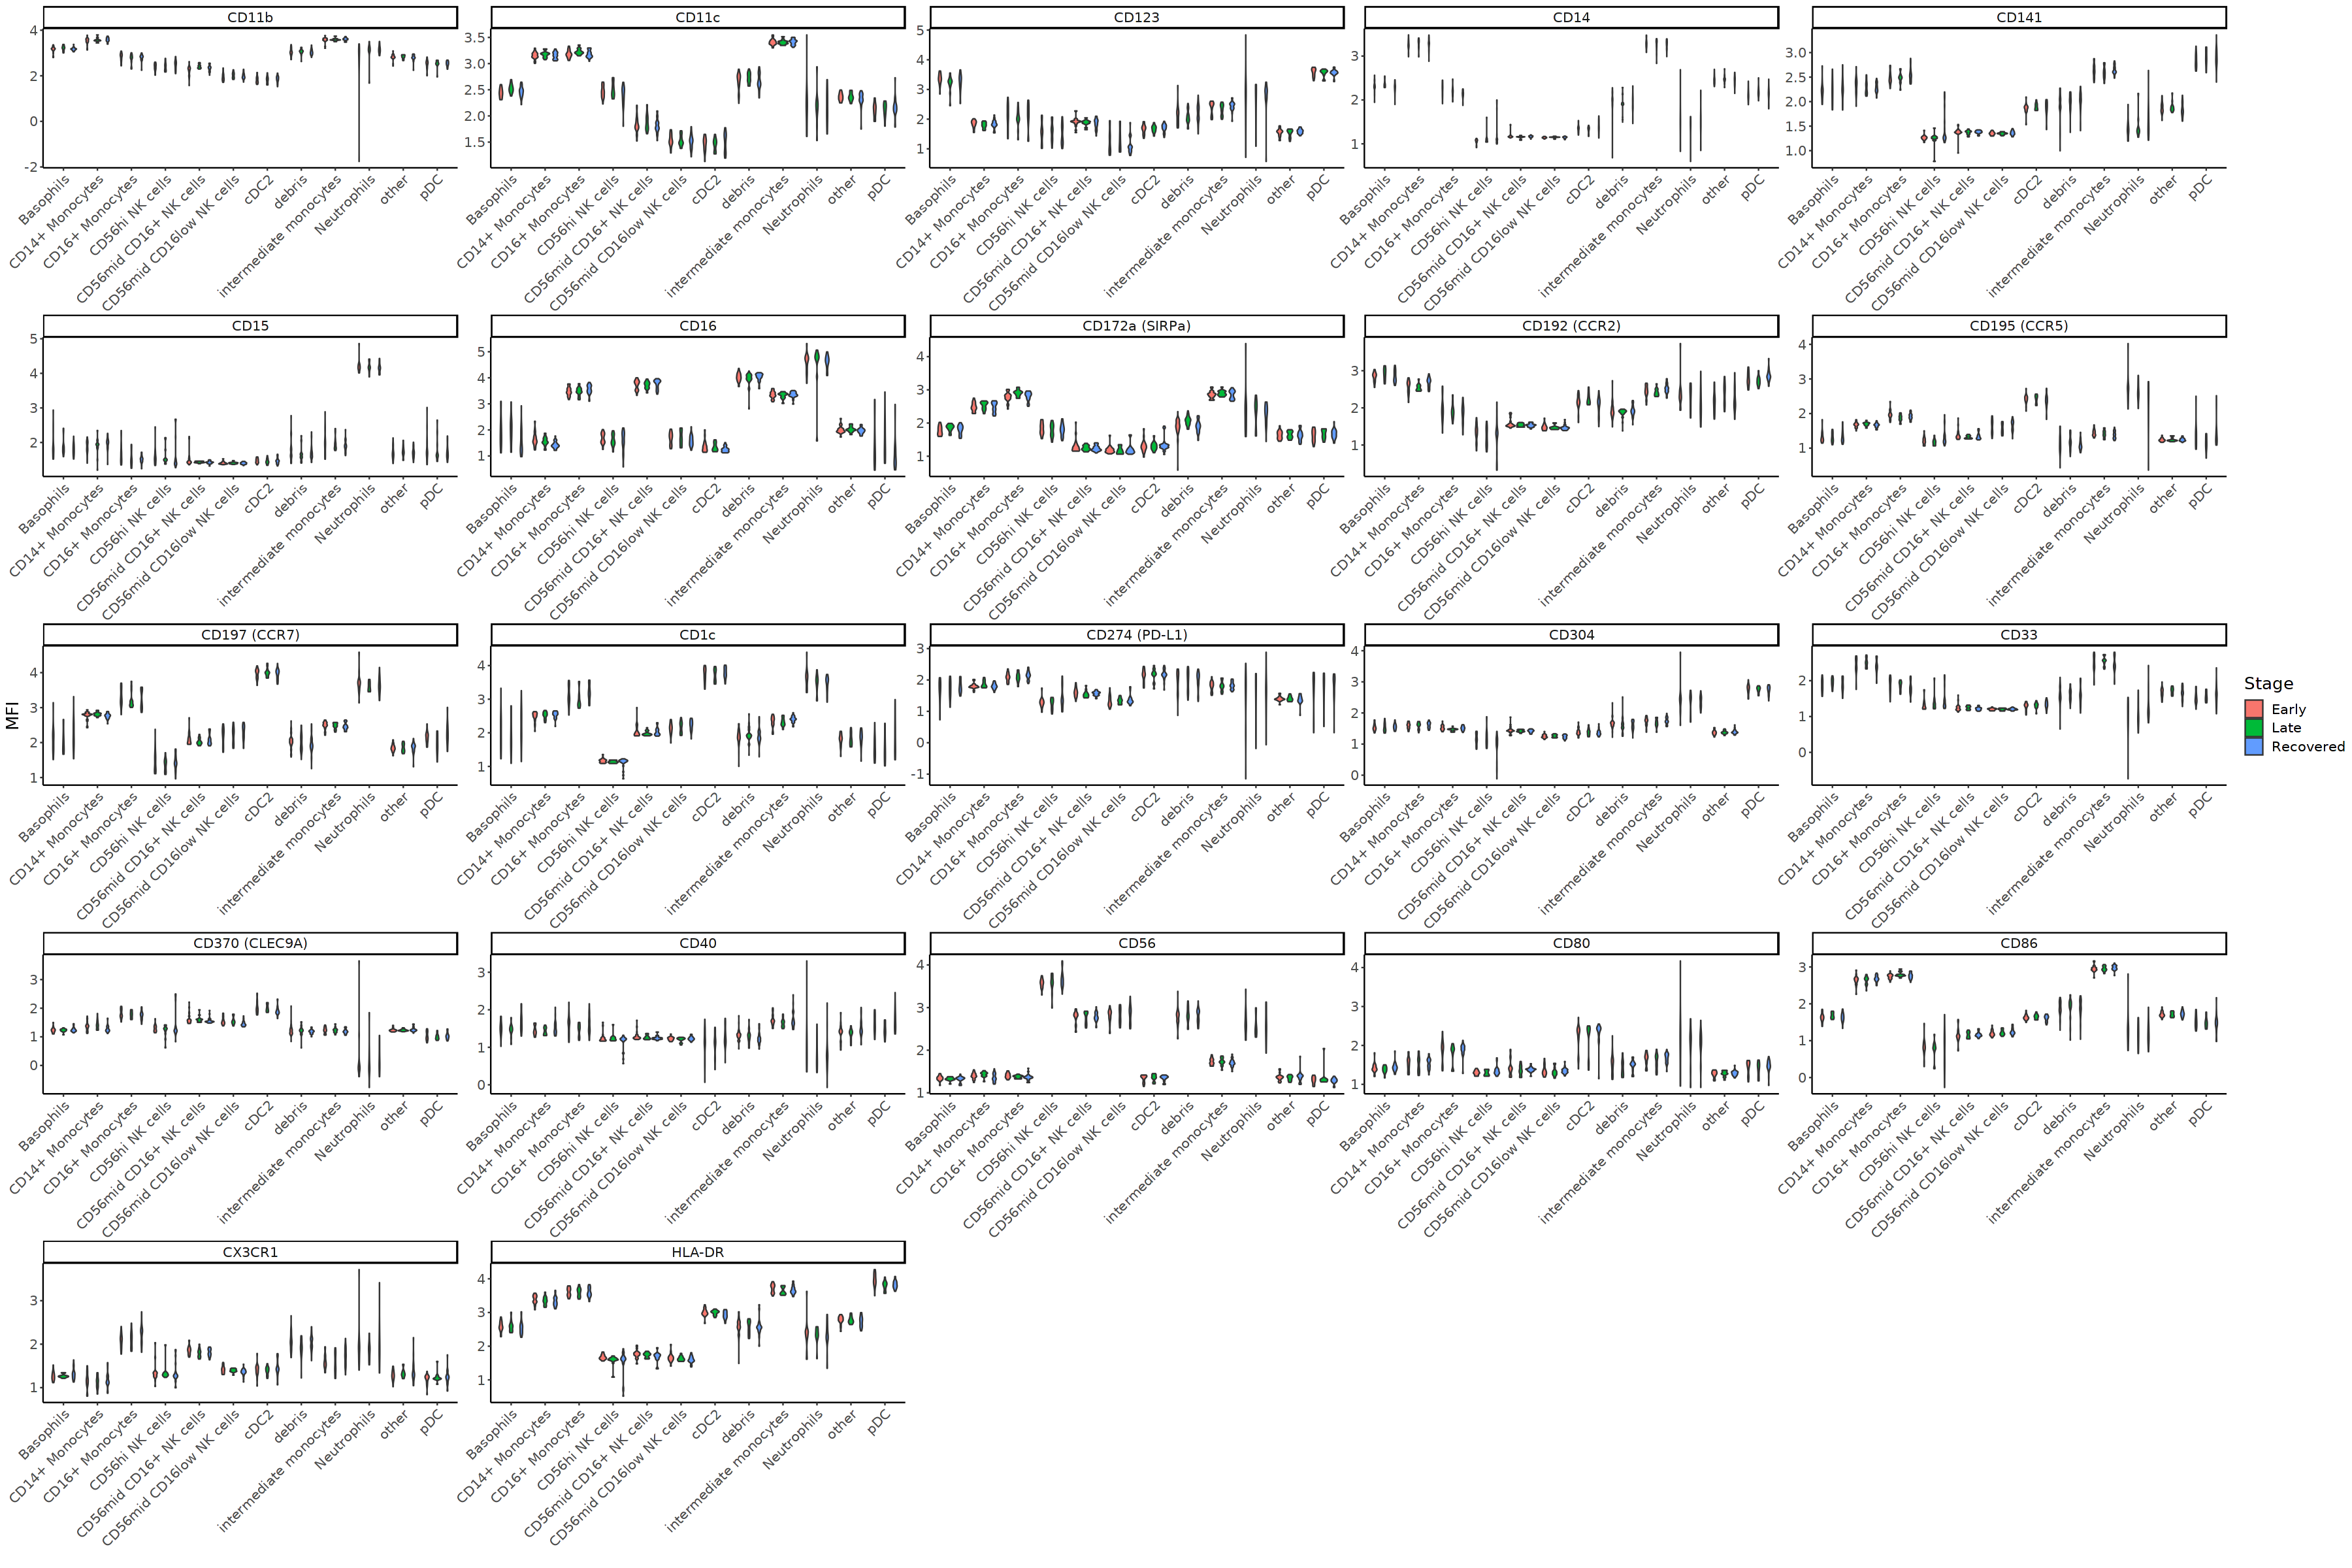

In [369]:
# by celltype
fig.size(20,30) 

ggplot(mfi_celltype %>% filter(Stage %in% c("Early", "Late", "Recovered")), aes(x=celltype,y=avg_mfi, fill = Stage)) + 
    geom_violin() +
    facet_wrap(~markers, scales="free") + 
    theme_classic() + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) + ylab("MFI") + xlab("") + theme(text = element_text(size=15))

### Old vs young

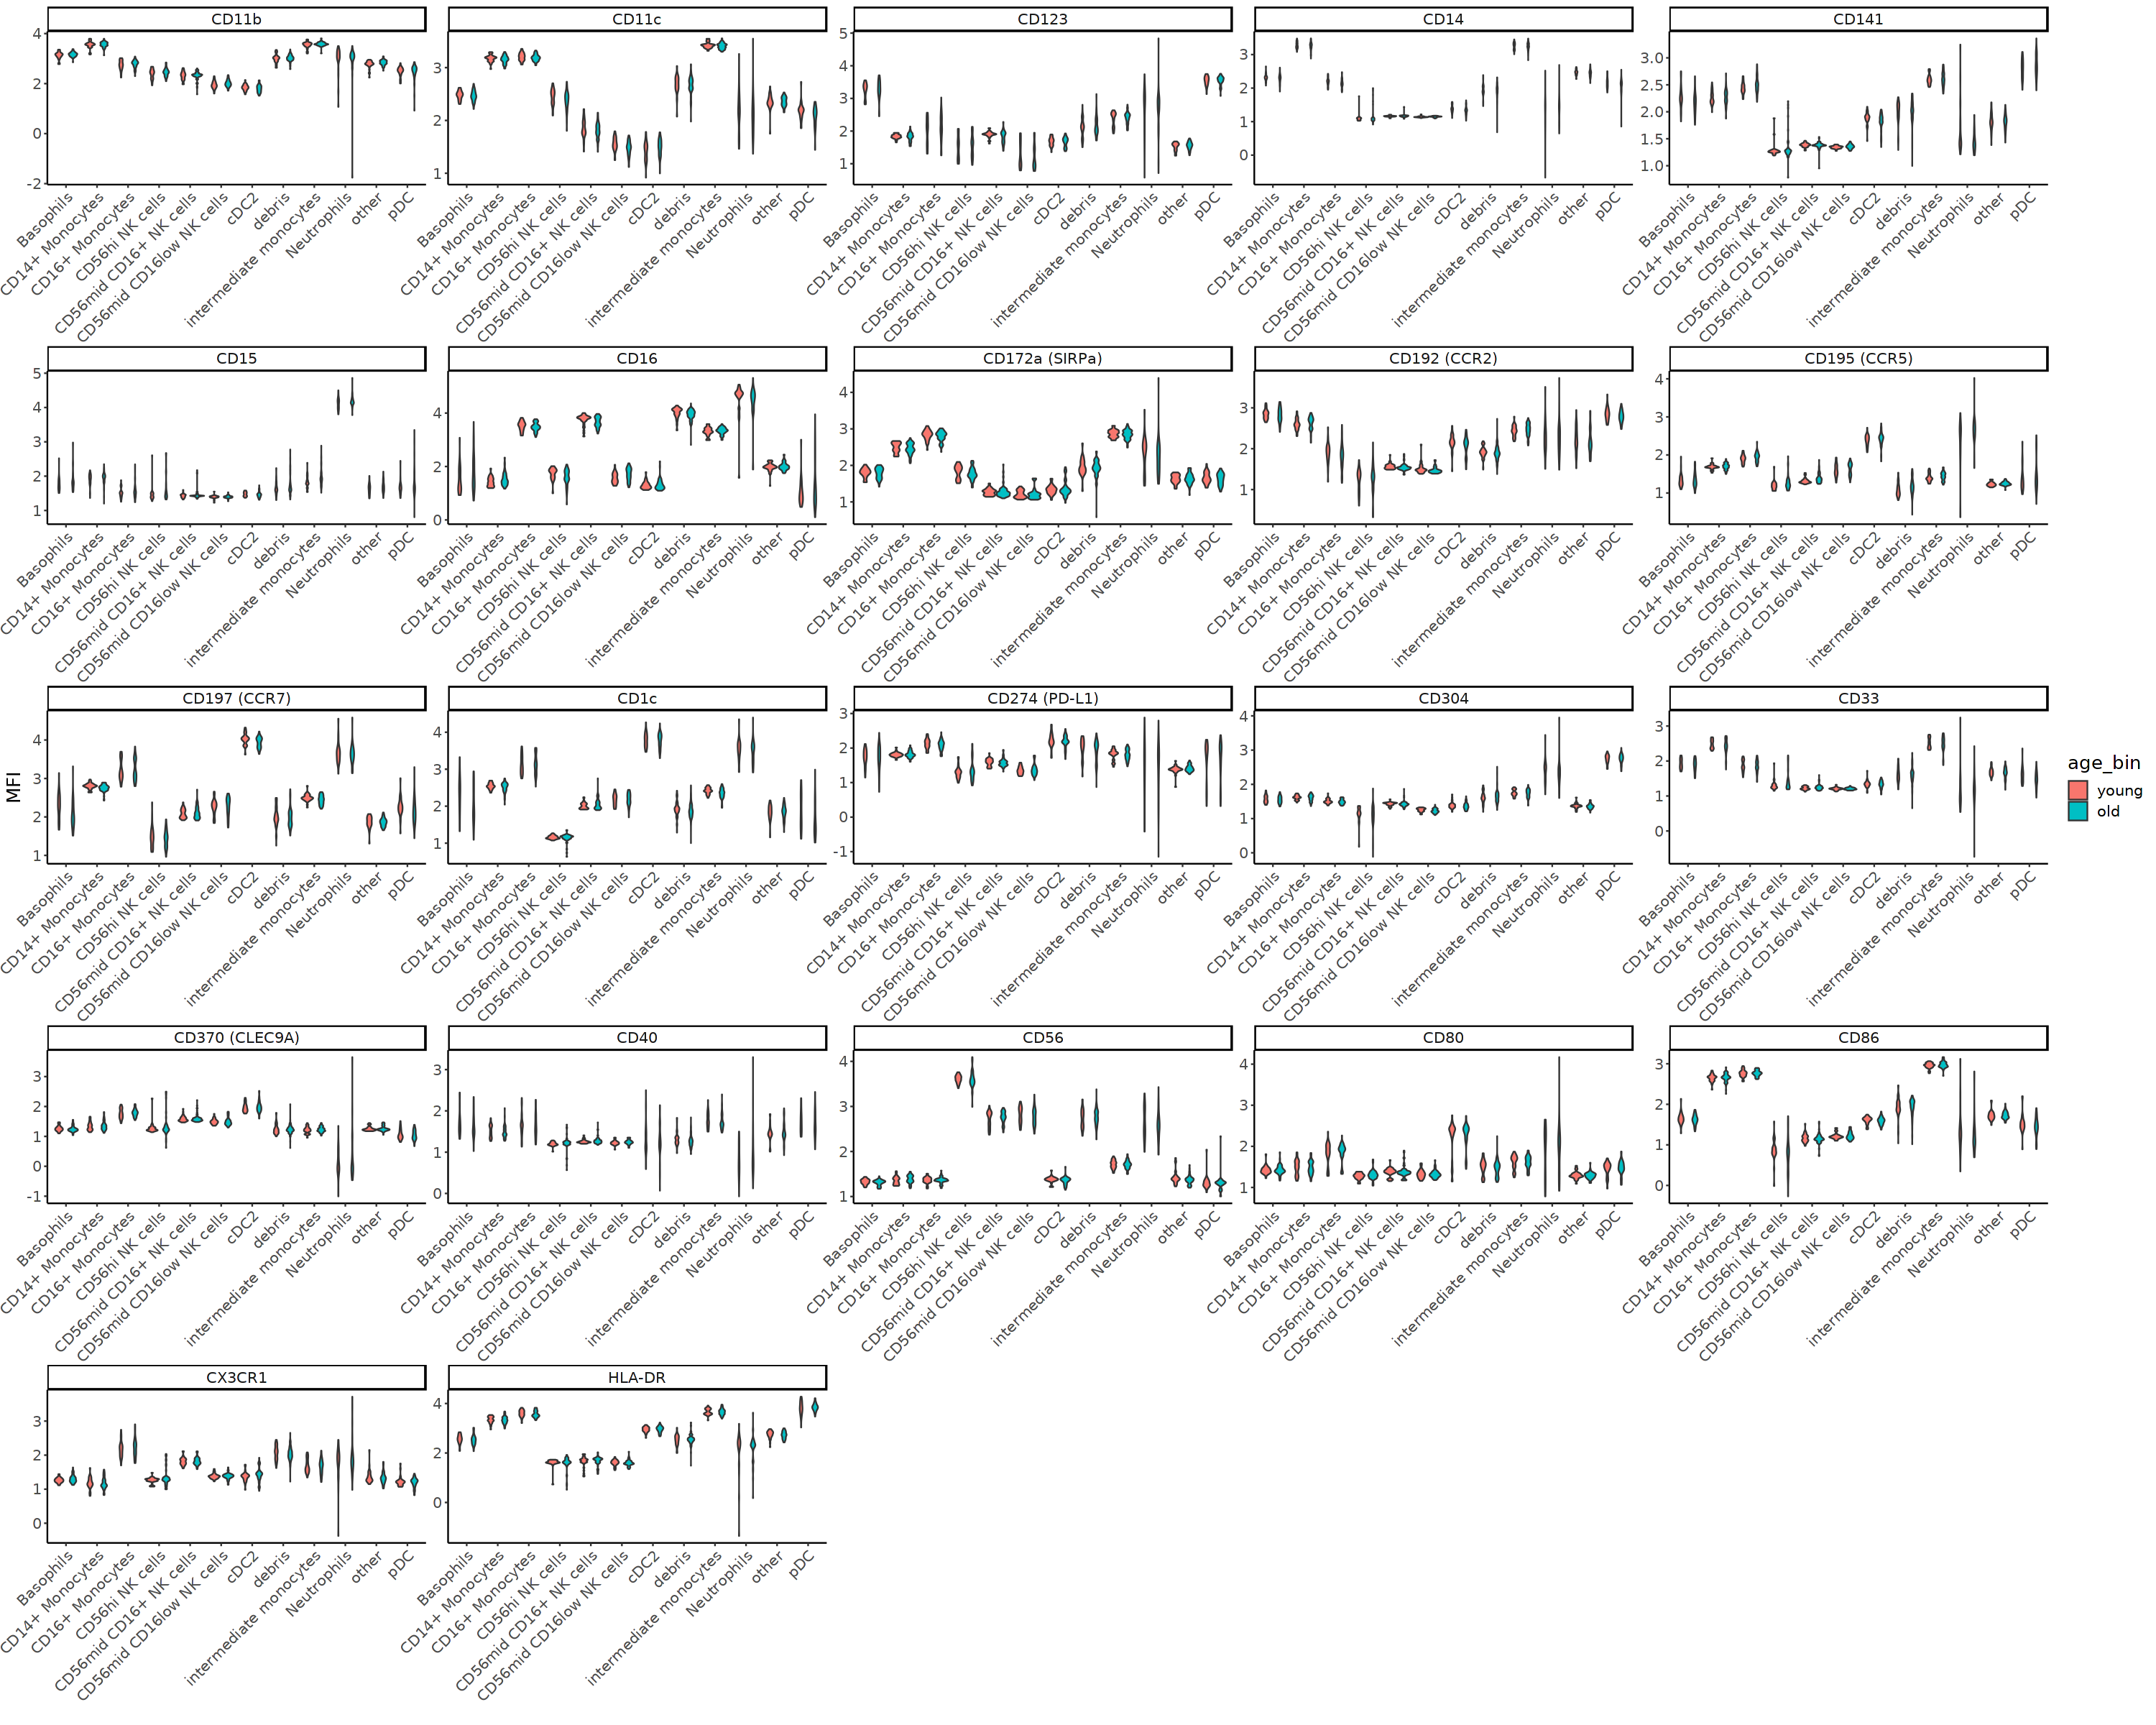

In [370]:
# by celltype
fig.size(20,25) 

mfi_celltype$age_bin <- str_replace(mfi_celltype$age_bin, "eradults", "") %>% 
                                factor(levels = c("young", "old"))
ggplot(mfi_celltype, aes(x=celltype,y=avg_mfi, fill = age_bin)) + 
    geom_violin() +
    facet_wrap(~markers, scales="free") + 
    theme_classic() + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) + ylab("MFI") + xlab("") + theme(text = element_text(size=15))